<a href="https://www.kaggle.com/code/aletbm/cardiovascular-diseases-eda-modeling?scriptVersionId=148251497" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🏥 Cardiovascular Diseases - EDA + Modeling
<img src="https://wallpapercave.com/wp/wp11622731.jpg" width=100%>

In [1]:
!pip install missingno
!pip install mplcyberpunk

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# ⚙️ Loading libraries

In [3]:
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import missingno as msno

import mplcyberpunk
import random

plt.style.use("cyberpunk")

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# 📜 About this dataset
## Feature description
+ **Age**: age of the patient [years]
+ **Sex**: sex of the patient [M: Male, F: Female]
+ **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
+ **RestingBP**: resting blood pressure [mm Hg]
+ **Cholesterol**: serum cholesterol [mm/dl]
+ **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
+ **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
+ **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
+ **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
+ **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
+ **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
+ **HeartDisease**: output class [1: heart disease, 0: Normal]

In [5]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [6]:
df.shape

(918, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
continuos_f = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]
target = "HeartDisease"

In [9]:
df[continuos_f].describe()

Age   RestingBP  Cholesterol       MaxHR     Oldpeak
count  918.000000  918.000000   918.000000  918.000000  918.000000
mean    53.510893  132.396514   198.799564  136.809368    0.887364
std      9.432617   18.514154   109.384145   25.460334    1.066570
min     28.000000    0.000000     0.000000   60.000000   -2.600000
25%     47.000000  120.000000   173.250000  120.000000    0.000000
50%     54.000000  130.000000   223.000000  138.000000    0.600000
75%     60.000000  140.000000   267.000000  156.000000    1.500000
max     77.000000  200.000000   603.000000  202.000000    6.200000

In [10]:
df[categorical_f].describe()

ChestPainType RestingECG ST_Slope
count            918        918      918
unique             4          3        3
top              ASY     Normal     Flat
freq             496        552      460

# ✂️ Division into training and test sets

In [11]:
train_X, test_X, train_y, test_y = train_test_split(df.drop([target], axis=1), df[target], test_size=0.25, random_state=42, stratify=df[target])
train_X.shape, test_X.shape

((688, 11), (230, 11))

# ⚠️ Remove duplicates and check for null values

## Duplicated data

In [12]:
print(f"Amount of repeated data in train set: {train_X.duplicated().sum()}")
print(f"Amount of repeated data in test set: {test_X.duplicated().sum()}")

Amount of repeated data in train set: 0
Amount of repeated data in test set: 0


## Null values

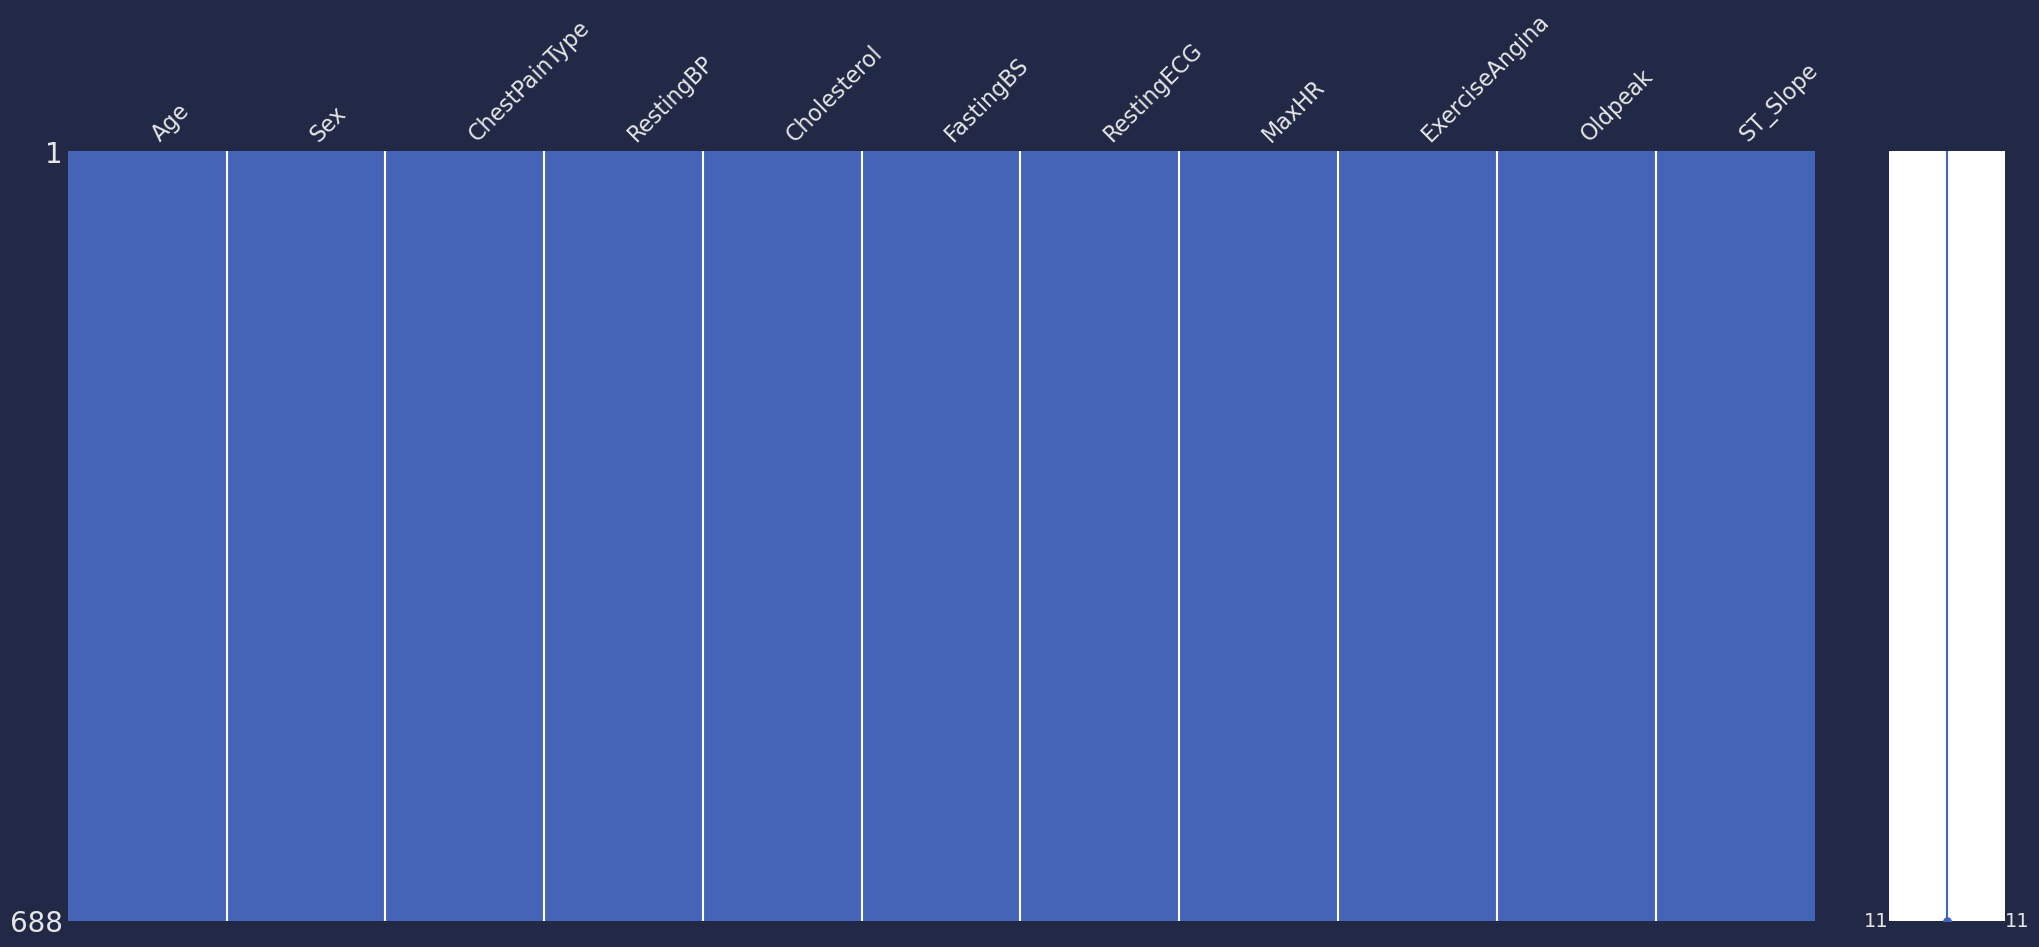

In [13]:
msno.matrix(train_X, color=(68/255, 100/255, 184/255));

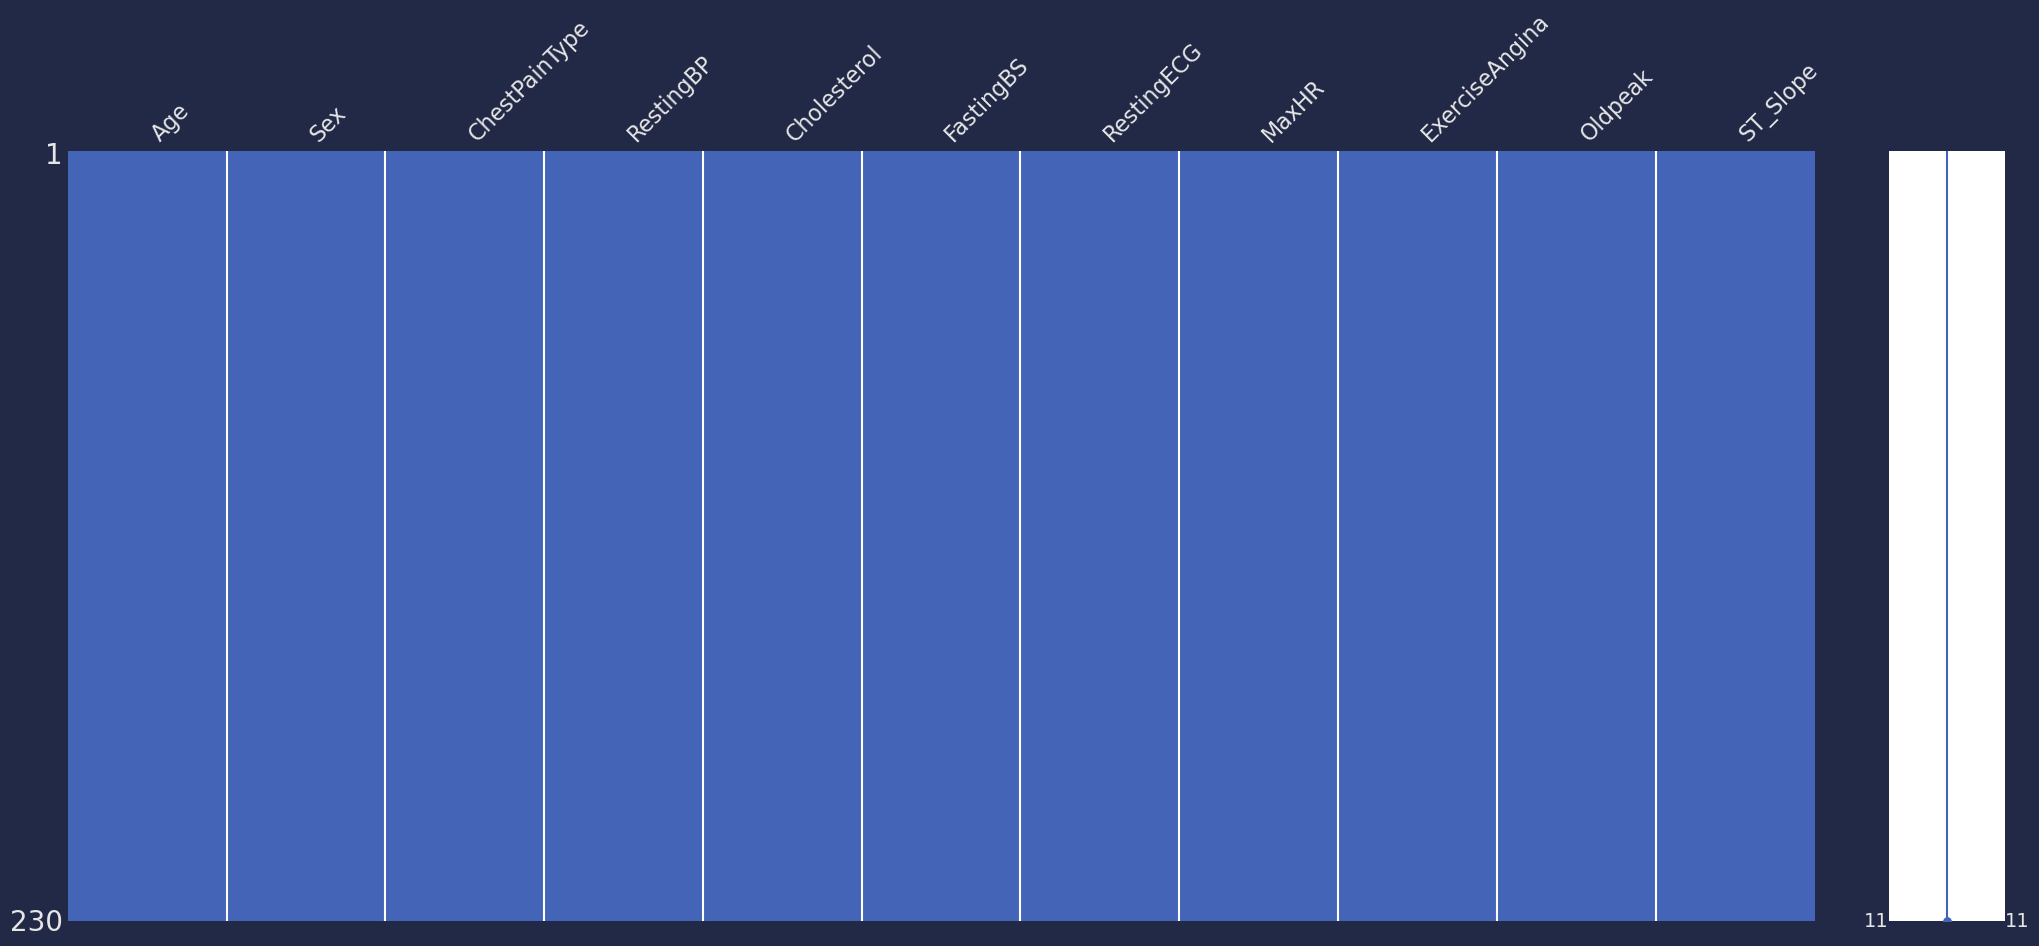

In [14]:
msno.matrix(test_X, color=(68/255, 100/255, 184/255));

# 📊 EDA and data wrangling 

<Figure size 640x480 with 0 Axes>

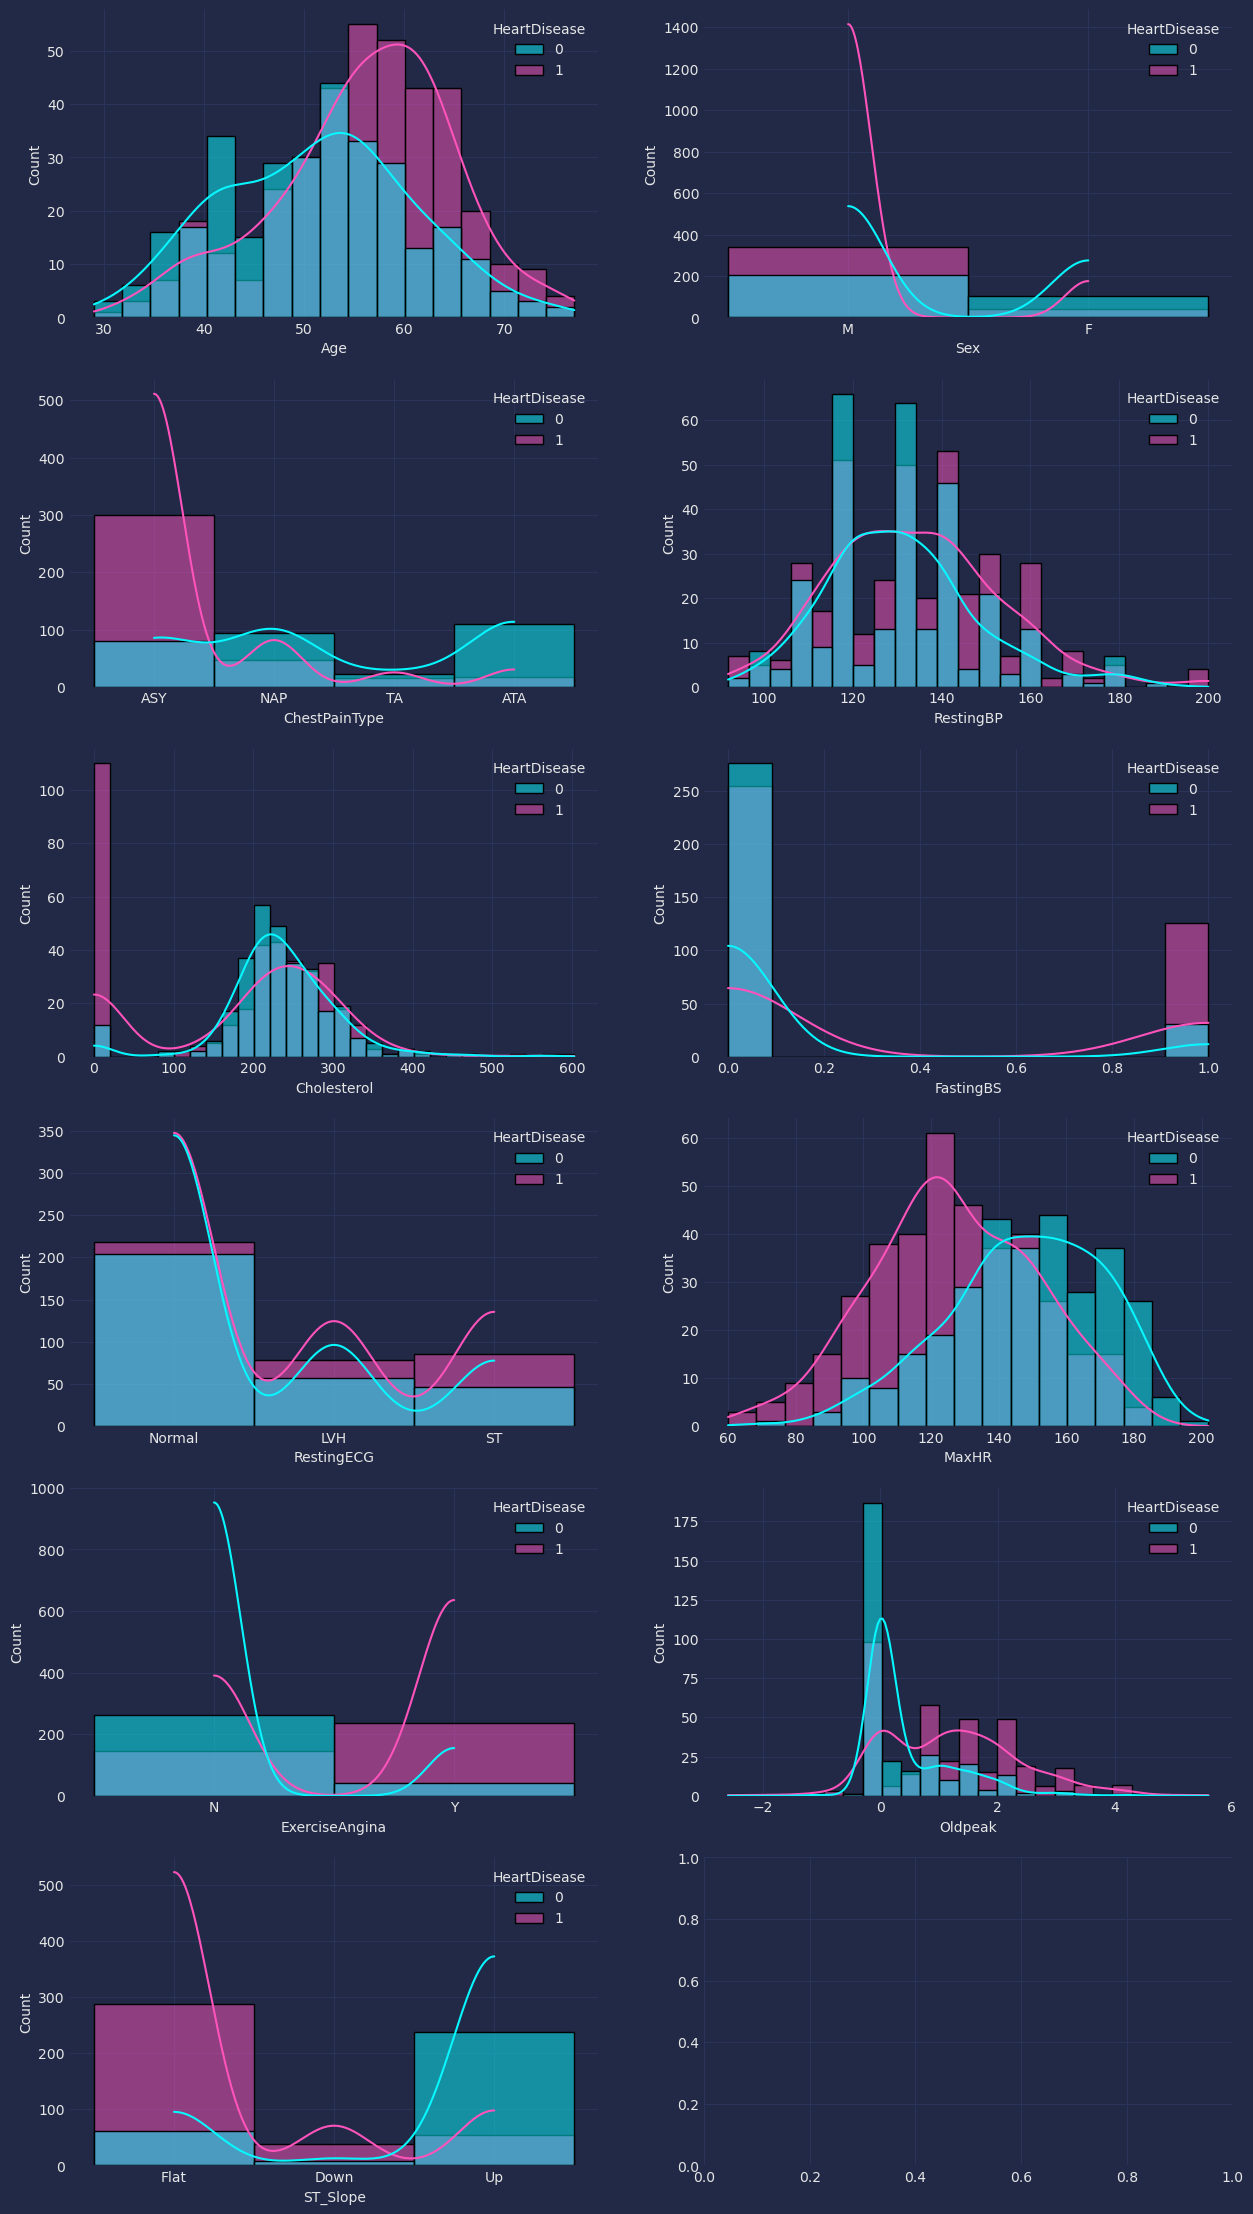

In [15]:
plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in train_X.columns:
    plt.subplot(6,2,i)
    sns.histplot(data=pd.concat([train_X, train_y], axis=1), x=feature, kde=True, hue='HeartDisease')
    i+=1

 Based on this visualization, we will an analysis:
 + **Age**: We see how the risk of suffering cardiovascular diseases (CVDs) increases with age.
 + **Sex**: Apparently the men have a major risk than women of suffering CVDs.
 + **ChestPainType**: The majority cases of CVDs present absence of chest pain or the usual anginal equivalents. Followed by the cases that present chest pain non-anginal.
 + **RestingBP**: According to the [heart.org's article](https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure/how-high-blood-pressure-can-lead-to-heart-failure), the high blood pressure can drive to suffering CVDs. We see in this histogram a slight increase in the CVDs cases when increase the resting blood pressure. <span style="color:red; font-weight: bold;">Let's observe that exists zero values of blood pressure, this it is incorrect we must treat them</span>.
 + **Cholesterol**: It is well known that a high level of cholesterol can lead to stroke, heart attack, or even heart failure. However, according to the [Heatline's article](https://www.healthline.com/health/serum-cholesterol) not all serum cholesterol is bad, exist three cholesterol types that compose a serum cholesterol, HDL or 'good' cholesterol, LDL or 'bad' cholesterol and triglycerides(TG), where high HDL levels are better than high LDL and TG levels. The level of serum cholesterol (SC) can be calculated like the sum between levels of HDL, LDL and TG, SC[mm/dl] = HDL[mm/dl] + LDL[mm/dl] + TG[mm/dl], note that we don't know the concentrations of HDL, LDL and TG in serum cholesterol of our dataset, but Heatline get us a reference level to determinate when a pacient have risk of suffering CDVs. A serum cholesterol major than 200 mm/dl is considered a risk factor for health, let'us in our histogram that majority cases of CVDs have major levels that 200 mm/dl. In other hand, <span style="color:red; font-weight: bold;">let's observe that exists zero values and value too high (atypical cases) of serum cholesterol, this it is incorrect we must treat them</span>.
 + **FastingBS**: According to [CDC's article](https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.), high blood sugar can damage blood vessels and the nerves that control your heart. For this reason is that patients with diabetes have most risk of suffering CVDs. Our dataset reflect this condition, where the majority of patients with high blood sugar have CVDs.
 + **RestingECG**: The majority cases of patients with CVDs present normal resting electrocardiograms, but we observe that in the cases that present ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) the amount of patients with CVDs are two times more than patientes that not suffering CVDs, something similar occurs with cases that present probable or definite left ventricular hypertrophy but to a lesser degree.
 + **MaxHR**: we don't know the conditions in which they were measured this values, so we can't talk about if this values can be to correct. The truth is that patients with CVDs present low values of maximum heart rate, while that patients with normal conditions present values more high.
 + **ExerciseAngina**: Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood. But angina is not a disease. It's a symptom of an underlying heart problem, and for this reason that the majority of patients with CVDs present exercise-induced angina.
 + **Oldpeak**: Also called ST segment depression is a factor that relationed with several CVD, but in some cases this depression can be normal. We can observe that patients with CVDs present high values of depression, though also some patients with CVDs present zero values of depression.
 + **ST_slope**: According to [Ecgwaves's article](https://ecgwaves.com/topic/ecg-st-segment-depression-ischemia-infarction-differential-diagnoses/), upsloping ST segment can be generally considered like normal, but so much flat or horizontal ST segment and dowsloping ST segment can be considered like anomalies, and they are present in the majority cases of patients with CVDs as reflected by our histogram.
 

### Outlier Detection

We have previously seen that features like cholesterol and resting blood pressure present atypical cases, this cases not represent the condition of general population and this data type we don't useful to train our model of predictions, let's see how to treat them:

<Figure size 640x480 with 0 Axes>

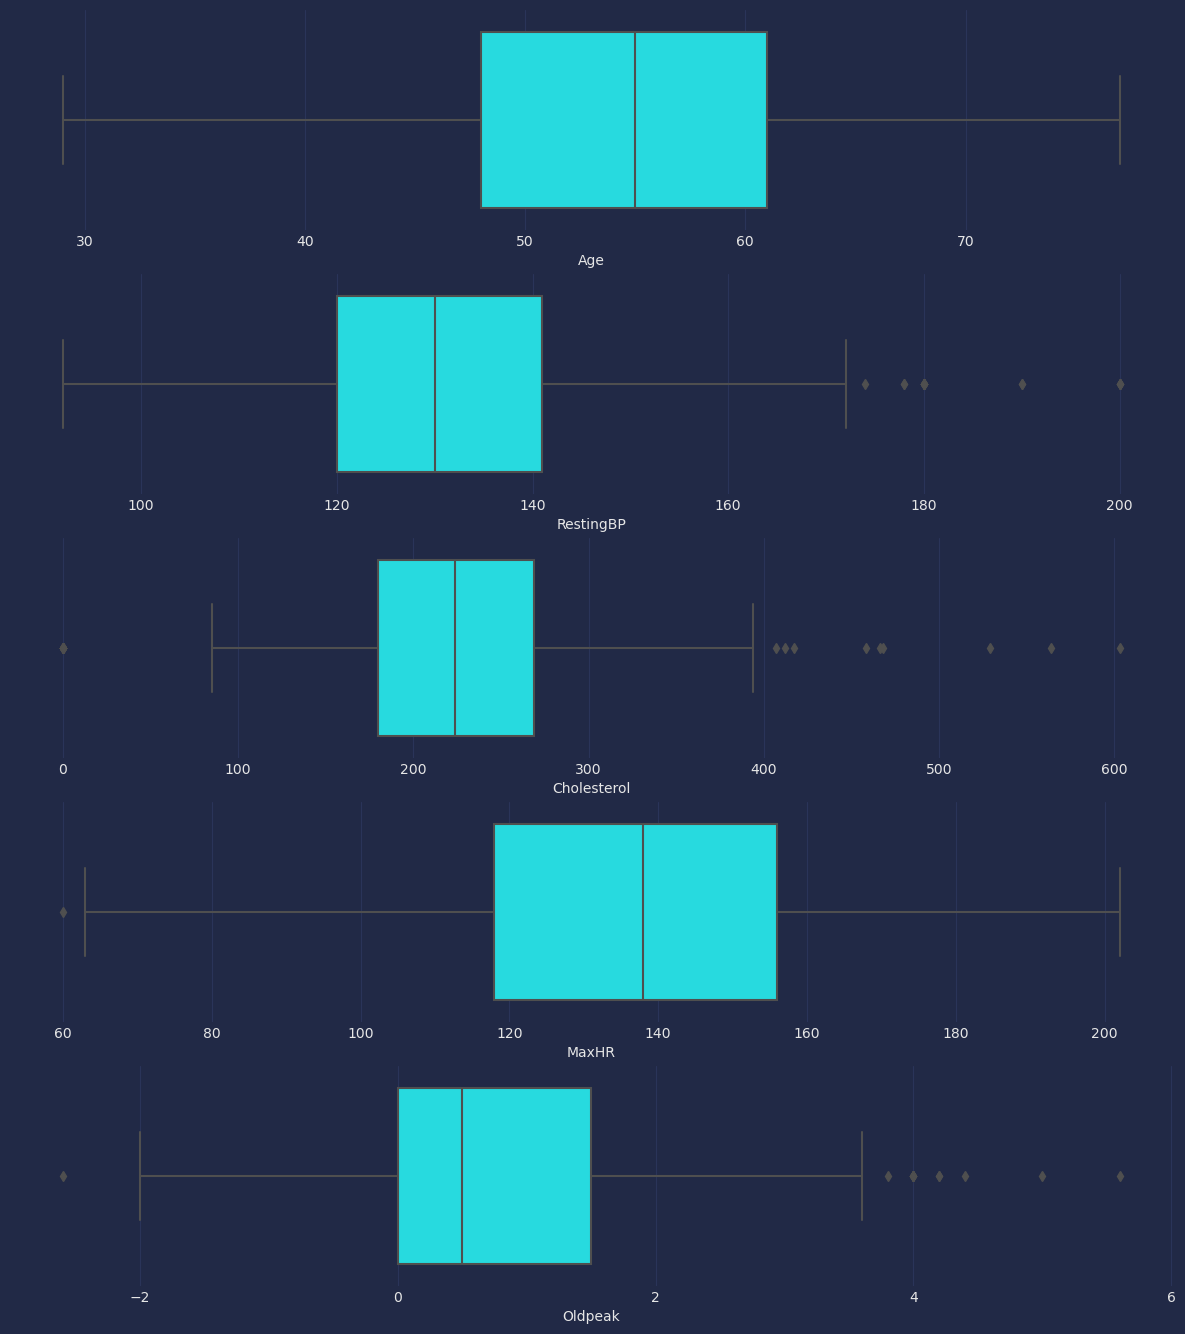

In [16]:
plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(5, 1, figsize=(15,20))
i=1
for feature in continuos_f:
    plt.subplot(6,1,i)
    sns.boxplot(data=train_X, x=feature)
    i+=1

<Figure size 640x480 with 0 Axes>

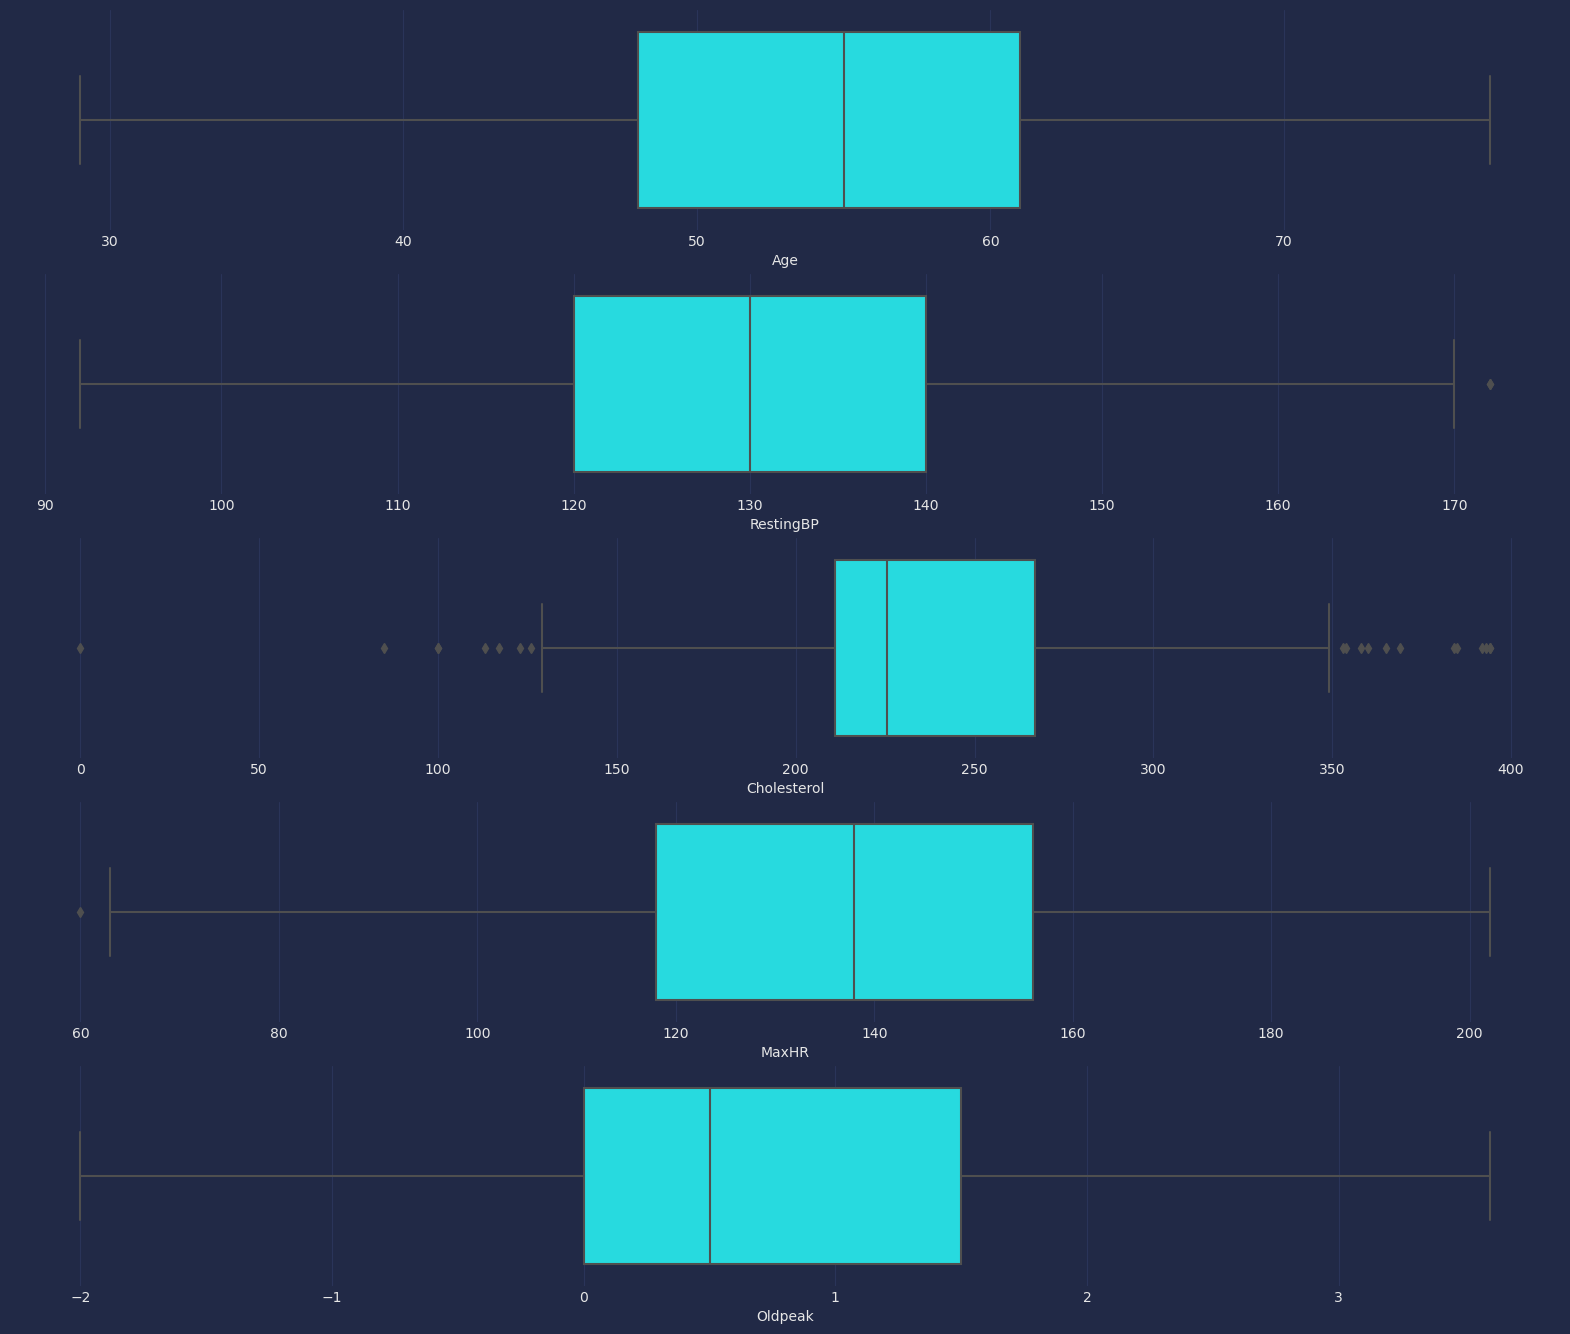

In [17]:
def detect_outliers(train, columns, tipo="leve", test=None):
    train_ = train.copy()
    test_ = test.copy()
    if tipo == "extremo":
        k = 3
    else:
        k = 1.5
    describe = train_.describe()
    for col in columns:
        Q1 = train_[col].quantile(0.25)
        Q3 = train_[col].quantile(0.75)
        IQR = Q3 - Q1
        for dataset in [train_, test_]:
            interval = ((dataset[col] < Q1 - k*IQR) | (dataset[col] > Q3 + k*IQR))
            dataset.loc[interval, col] = dataset.groupby(["ChestPainType", "RestingECG", "ST_Slope"])[col].transform('median')[interval]
    return train_, test_, describe

train_X_clean, test_X, describe = detect_outliers(train_X, ["RestingBP", "Cholesterol", "Oldpeak"], "leve", test_X)

plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(5, 1, figsize=(20,20))
i=1
for feature in continuos_f:
    plt.subplot(6,1,i)
    sns.boxplot(data=train_X_clean, x=feature)
    i+=1

We have values of zeros in the Cholesterol feature, these values are a human error since a patient with a zero cholesterol value means that he is dead. We can eliminate these values, but first we see the number of zeros since if the number is large we cannot eliminate them.

In [18]:
print(f"These values of zeros represent the {len(train_X_clean[train_X_clean['Cholesterol'] == 0])*100/len(train_X_clean)}% of our dataset")

These values of zeros represent the 0.14534883720930233% of our dataset


In [19]:
train_X_clean[train_X_clean["Cholesterol"] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
518   48   M           NAP      102.0          0.0          1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  
518    110              Y      1.0     Down

We can eliminate them.

In [20]:
index = train_X_clean[train_X_clean["Cholesterol"] == 0].index
train_X_clean.drop(index, axis=0, inplace=True)
train_y.drop(index, axis=0, inplace=True)

### 📈 Before and after cleaning outliers:

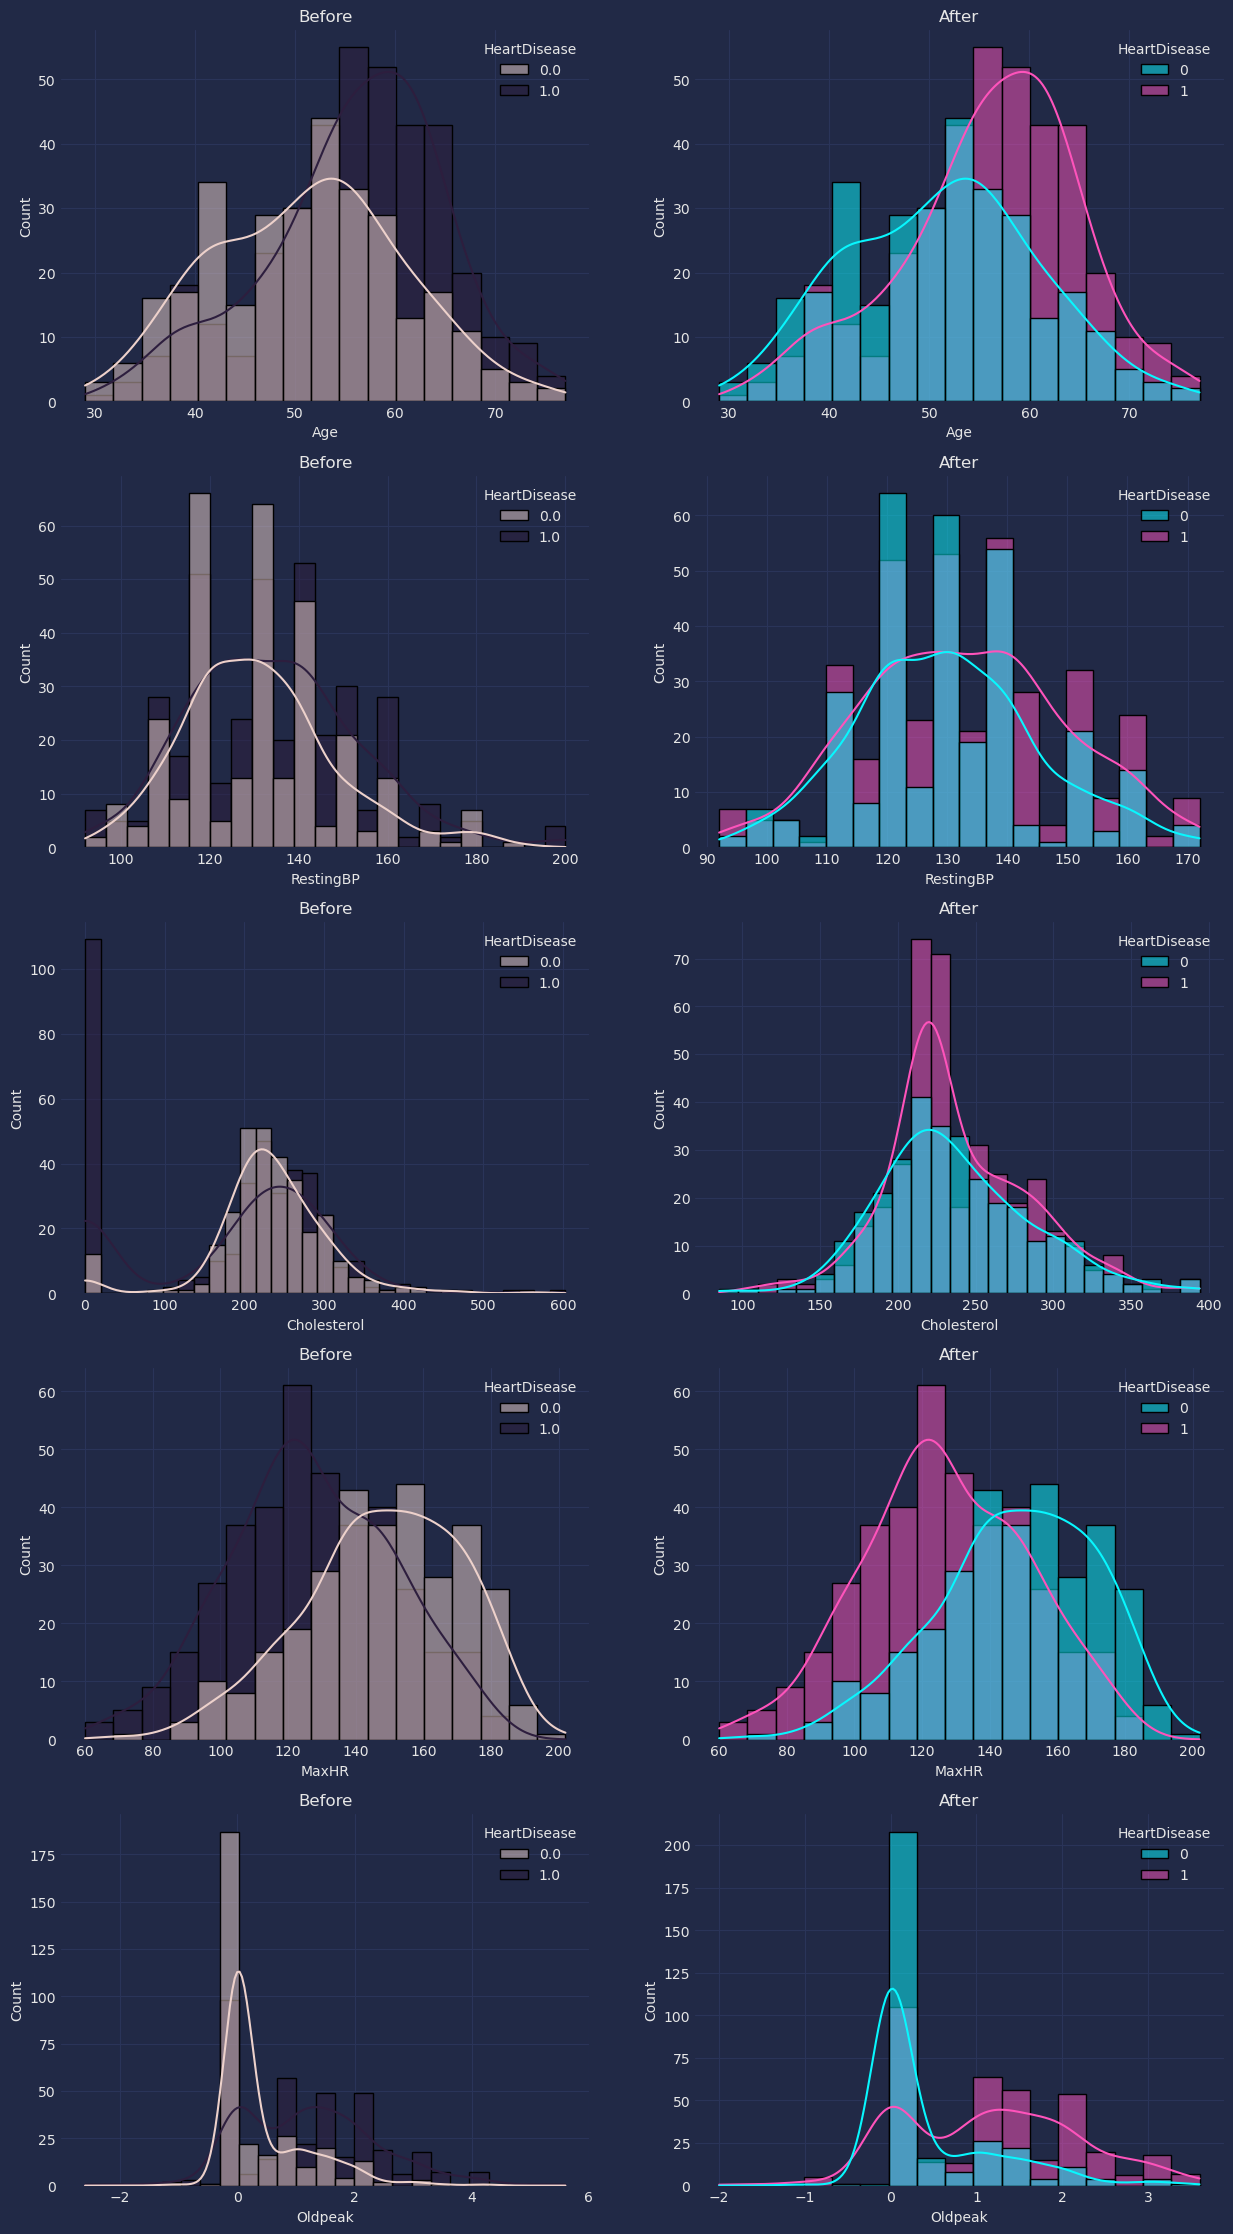

In [21]:
fig, axs = plt.subplots(5, 2, figsize=(15,28))
i=0
for feature in continuos_f:
    sns.histplot(data=pd.concat([train_X, train_y], axis=1), x=feature, kde=True, hue='HeartDisease', ax=axs[i][0])
    sns.histplot(data=pd.concat([train_X_clean, train_y], axis=1), x=feature, kde=True, hue='HeartDisease', ax=axs[i][1])
    axs[i][0].title.set_text("Before")
    axs[i][1].title.set_text("After")
    i+=1

In [22]:
train_X = train_X_clean
all_df = pd.concat([train_X, train_y], axis=1)

## Bivariate visualization

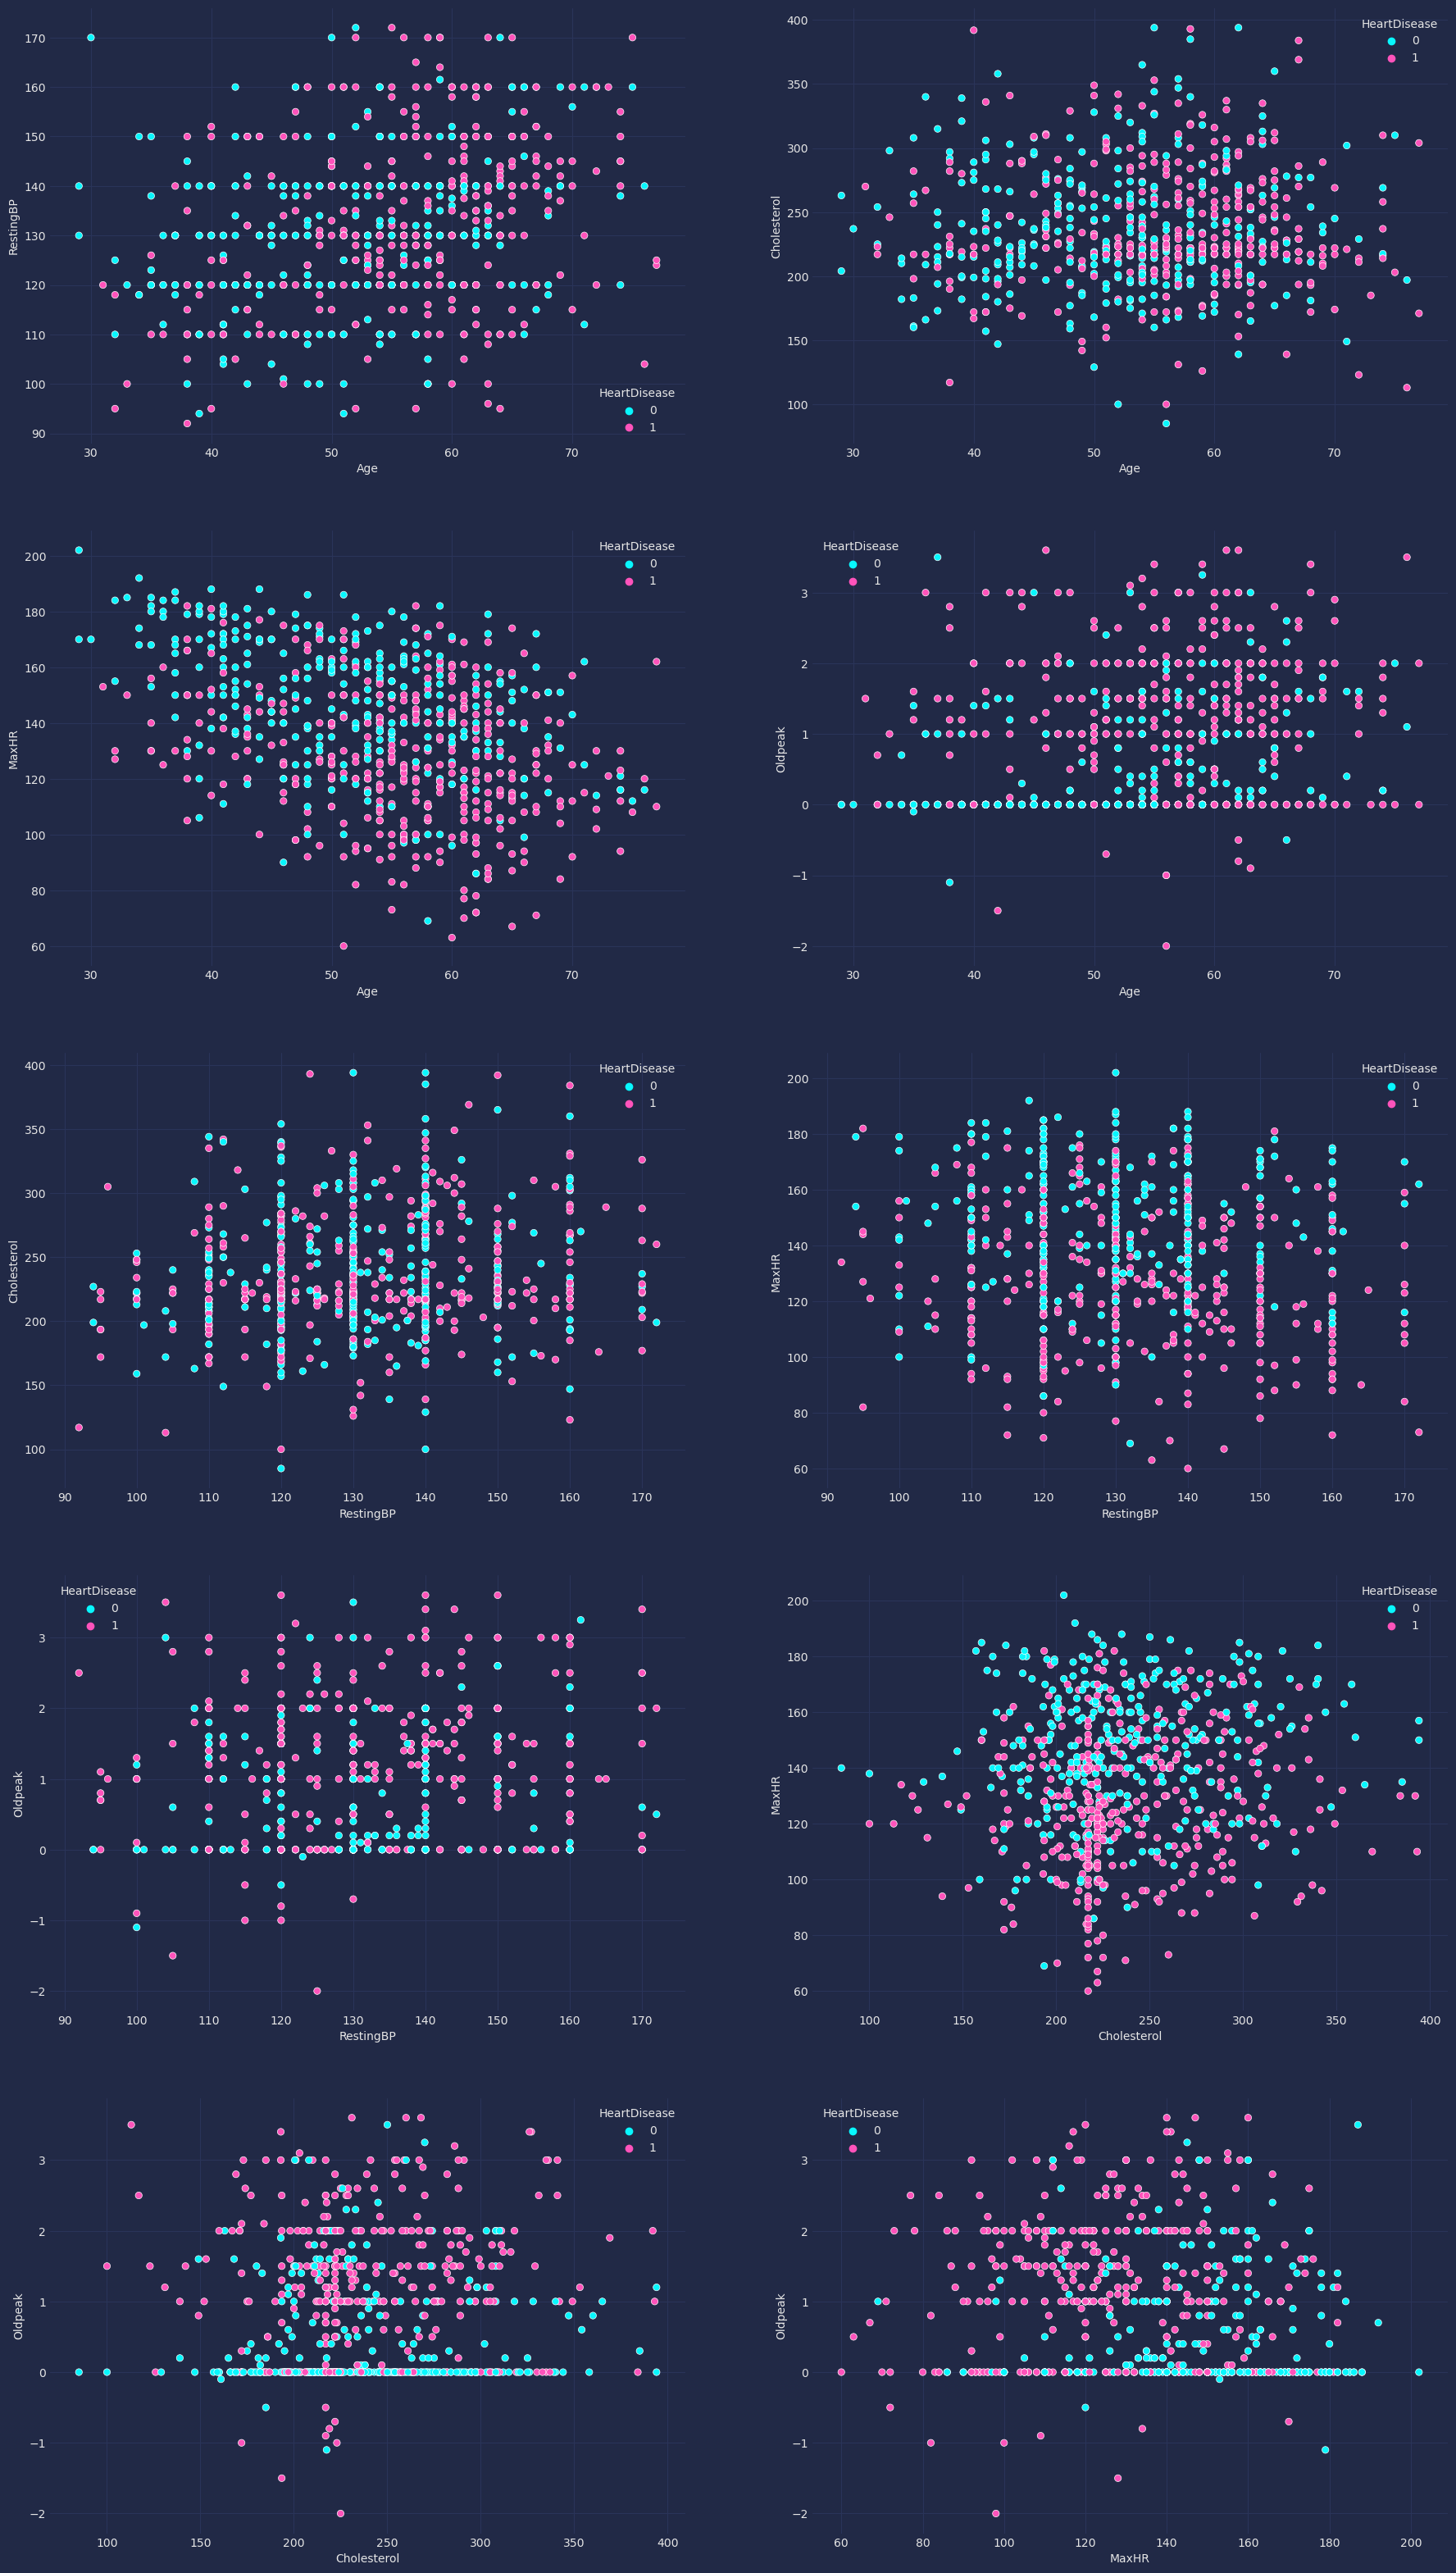

In [23]:
plt.subplots(5, 2, figsize=(22, 40))

continuos_f_cpy = continuos_f.copy()
i=0
for x in continuos_f:
    continuos_f_cpy.remove(x)
    for y in continuos_f_cpy:
        i+=1
        plt.subplot(5, 2, i)
        sns.scatterplot(data=all_df, x=x, y=y, hue="HeartDisease")

<Figure size 2000x4000 with 0 Axes>

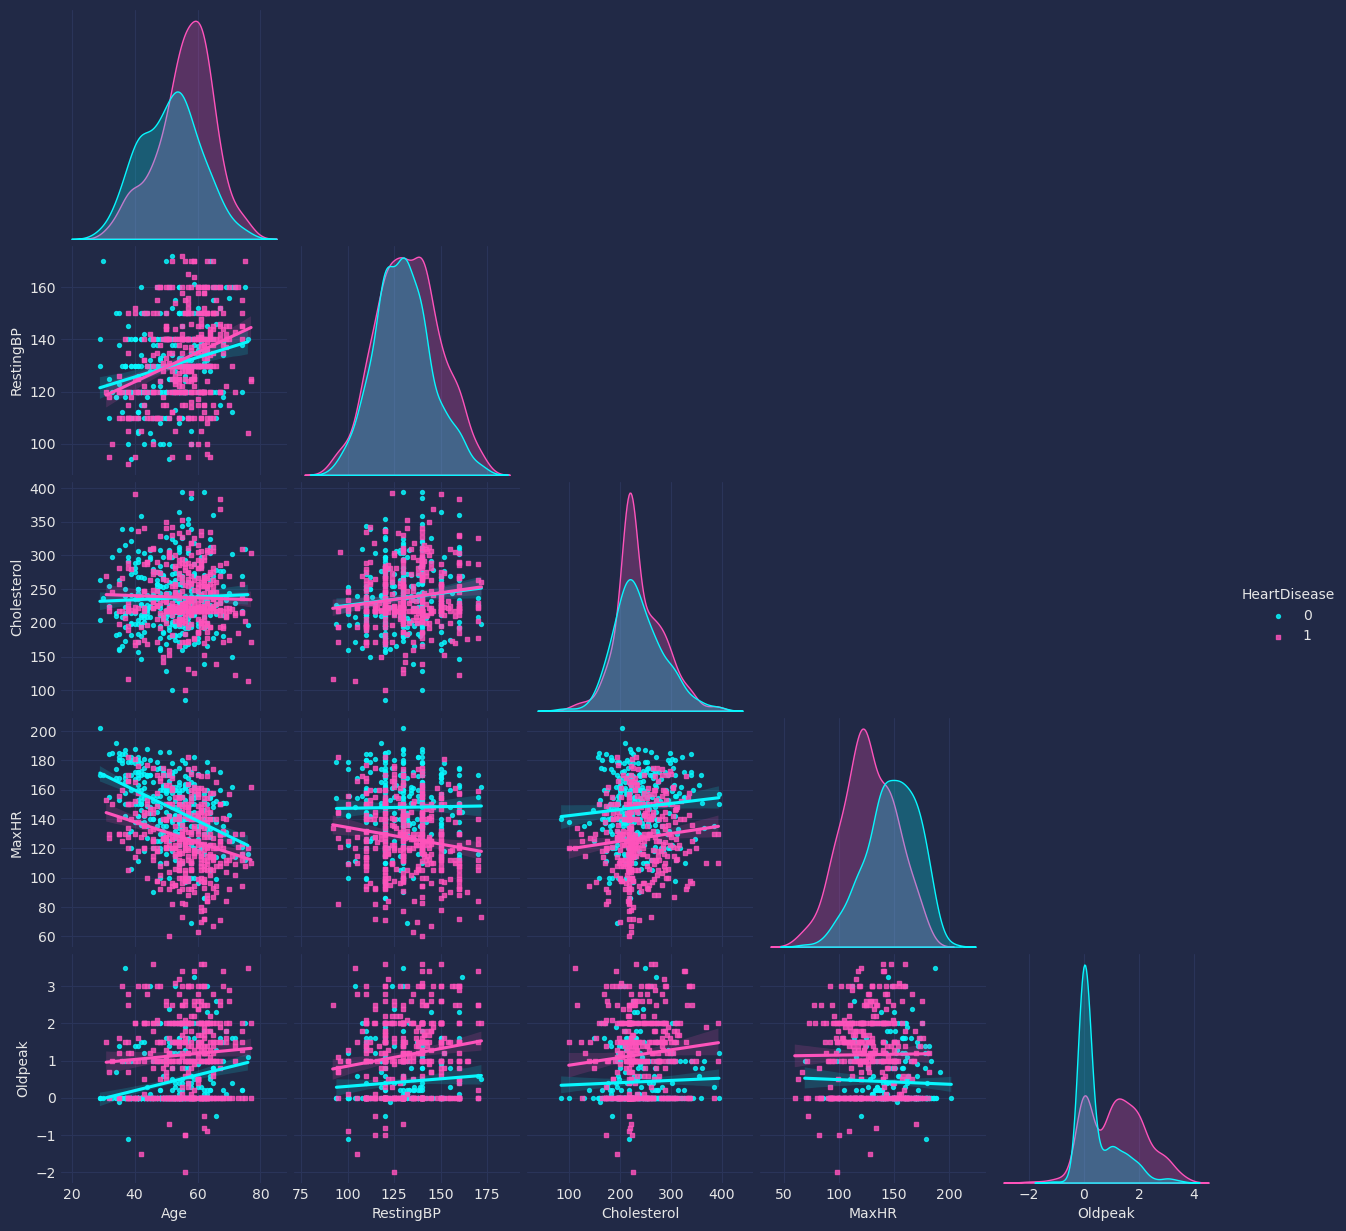

In [24]:
plt.figure(figsize=(20,40))
sns.pairplot(data=all_df[continuos_f+[target]], hue="HeartDisease", kind="reg", corner=True, markers=["o", "s"], plot_kws={ 'scatter_kws': {'alpha': 0.8, 's':8}});

## Showing balance of data

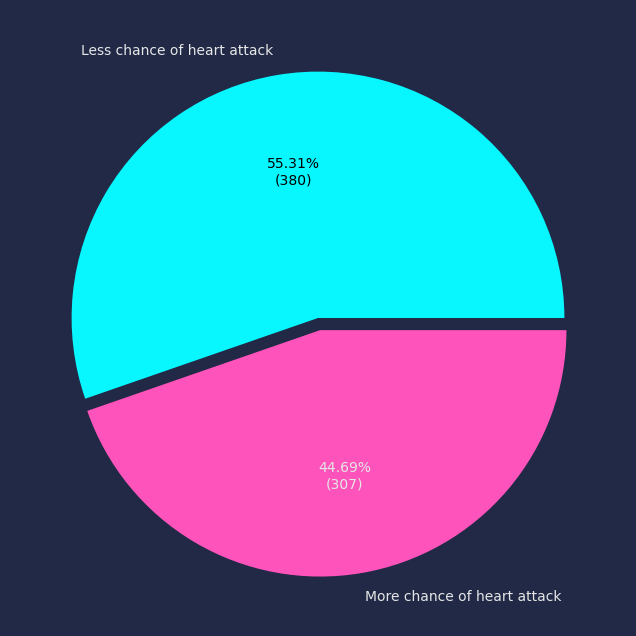

In [25]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%\n({v:d})'.format(pct, v=val)
        return my_format

labels = ["Less chance of heart attack", "More chance of heart attack"]

plt.figure(figsize=(8,8))
counts = train_y.value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

We have a slight imbalance in data.

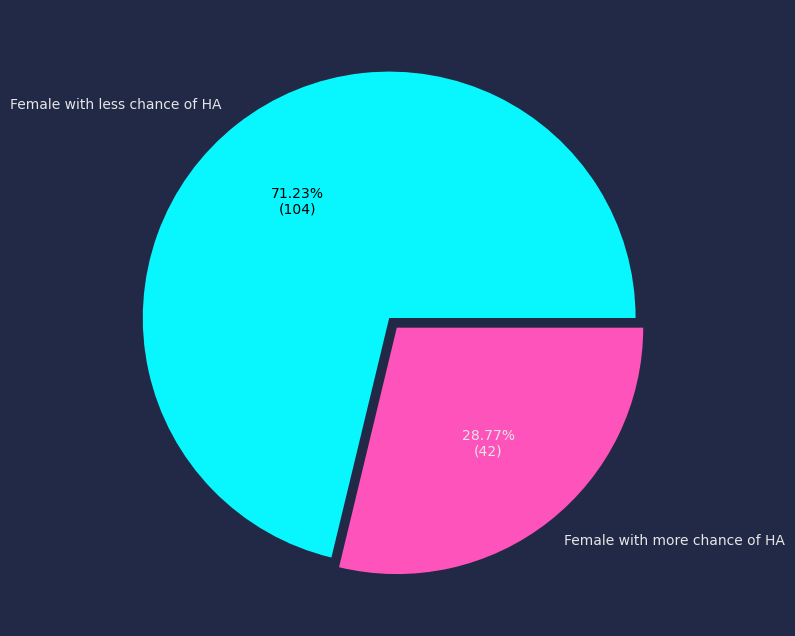

In [26]:
labels = ["Female with less chance of HA",
          "Female with more chance of HA"]

plt.figure(figsize=(8,8))
counts = all_df.loc[all_df["Sex"] == 'F',"HeartDisease"].value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

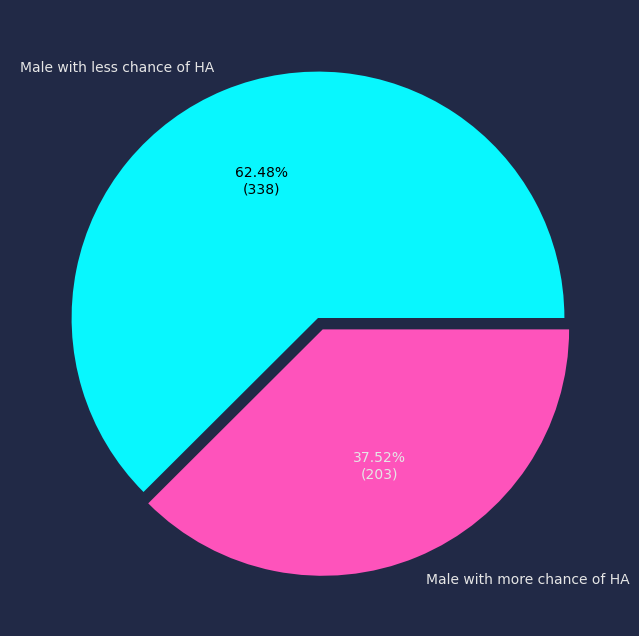

In [27]:
labels = ["Male with less chance of HA",
          "Male with more chance of HA"]

plt.figure(figsize=(8,8))
counts = all_df.loc[all_df["Sex"] == 'M',"HeartDisease"].value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

# 🔢 Features encoding

## Binary features enconding

In [28]:
for dataset in [train_X, test_X]:
    dataset["Sex"] = dataset["Sex"].map({'M':1, 'F':0})
    dataset["ExerciseAngina"] = dataset["ExerciseAngina"].map({'N':0, 'Y':1})
train_X

Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
637   43    1           ASY      115.0        303.0          0     Normal   
541   76    1           NAP      104.0        113.0          0        LVH   
570   56    1           ASY      128.0        223.0          0         ST   
611   62    1            TA      135.0        139.0          0         ST   
685   61    1           ASY      120.0        260.0          0     Normal   
..   ...  ...           ...        ...          ...        ...        ...   
321   63    1           ASY      100.0        217.0          1     Normal   
315   74    1           ATA      145.0        214.0          1         ST   
819   55    1           ASY      160.0        289.0          0        LVH   
355   67    1            TA      145.0        219.0          0        LVH   
62    45    1           ASY      140.0        224.0          0     Normal   

     MaxHR  ExerciseAngina  Oldpeak ST_Slope  
637    181               0      1.2     Flat  
541    120               0      3.5     Down  
570    119               1      2.0     Down  
611    137               0      0.2       Up  
685    140               1      3.6     Flat  
..     ...             ...      ...      ...  
321    109               0     -0.9     Flat  
315    123               0      1.3       Up  
819    145               1      0.8     Flat  
355    125               0      0.0     Flat  
62     144               0      0.0       Up  

[687 rows x 11 columns]

## One-hot encoding

In [29]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(train_X[categorical_f])

for dataset in [train_X, test_X]:
    dataset[ohe.get_feature_names_out()] = ohe.transform(dataset[categorical_f]).toarray().astype('int8')
    dataset.drop(categorical_f, axis=1, inplace=True)

train_X

Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
637   43    1      115.0        303.0          0    181               0   
541   76    1      104.0        113.0          0    120               0   
570   56    1      128.0        223.0          0    119               1   
611   62    1      135.0        139.0          0    137               0   
685   61    1      120.0        260.0          0    140               1   
..   ...  ...        ...          ...        ...    ...             ...   
321   63    1      100.0        217.0          1    109               0   
315   74    1      145.0        214.0          1    123               0   
819   55    1      160.0        289.0          0    145               1   
355   67    1      145.0        219.0          0    125               0   
62    45    1      140.0        224.0          0    144               0   

     Oldpeak  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
637      1.2                  1                  0                  0   
541      3.5                  0                  0                  1   
570      2.0                  1                  0                  0   
611      0.2                  0                  0                  0   
685      3.6                  1                  0                  0   
..       ...                ...                ...                ...   
321     -0.9                  1                  0                  0   
315      1.3                  0                  1                  0   
819      0.8                  1                  0                  0   
355      0.0                  0                  0                  0   
62       0.0                  1                  0                  0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
637                 0               0                  1              0   
541                 0               1                  0              0   
570                 0               0                  0              1   
611                 1               0                  0              1   
685                 0               0                  1              0   
..                ...             ...                ...            ...   
321                 0               0                  1              0   
315                 0               0                  0              1   
819                 0               1                  0              0   
355                 1               1                  0              0   
62                  0               0                  1              0   

     ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
637              0              1            0  
541              1              0            0  
570              1              0            0  
611              0              0            1  
685              0              1            0  
..             ...            ...          ...  
321              0              1            0  
315              0              0            1  
819              0              1            0  
355              0              1            0  
62               0              0            1  

[687 rows x 18 columns]

# 🔍 Looking for correlations

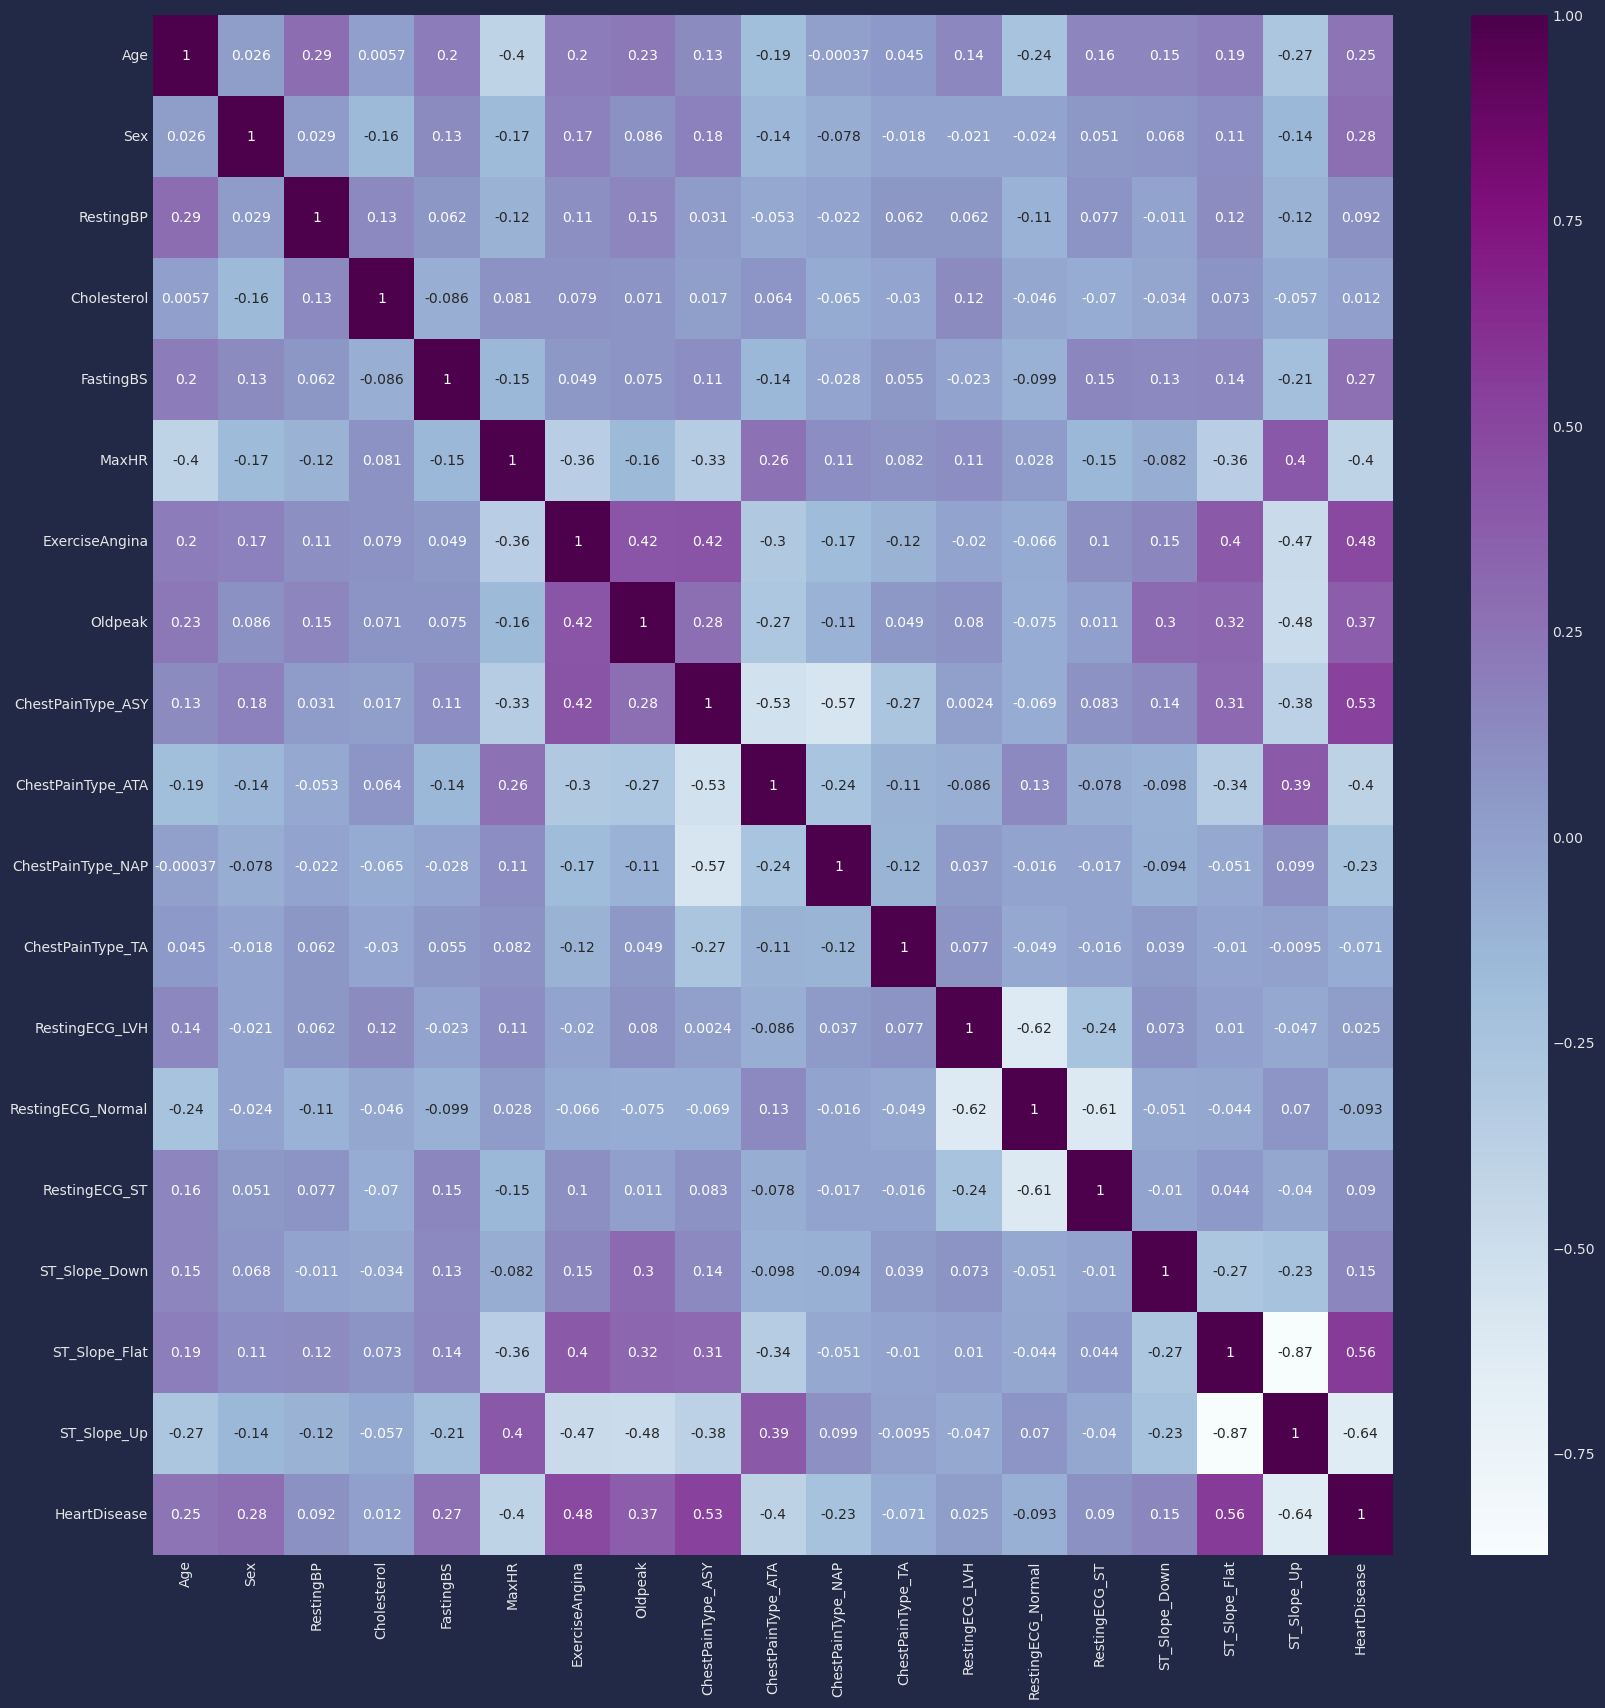

In [30]:
all_df = pd.concat([train_X, train_y], axis=1)
plt.figure(figsize=(20,20))
sns.heatmap(all_df.corr(), annot=True, cmap="BuPu");

## Checking multicollinearity problem

In [31]:
def detect_VIF(df):
    df_ = df.copy()
    df_['intercept'] = 1
    with np.errstate(divide='ignore'):
        while(True):
            df_vif = pd.DataFrame(columns=["Features", "VIF"])
            df_vif["Features"] = df_.columns
            df_vif["VIF"] = [variance_inflation_factor(df_.values, i) for i in range(len(df_.columns))]
            df_vif = df_vif[df_vif["Features"] != "intercept"].sort_values("VIF", ascending=False)
            if df_vif.iloc[0]["VIF"] > 5:
                df_.drop([df_vif.iloc[0]["Features"]], axis=1, inplace=True)
            else:
                next_ = False
                break
    df_.drop(["intercept"], axis=1, inplace=True)
    return df, df_vif
        
train_X, df_vif = detect_VIF(train_X)
df_vif

Features       VIF
8   ChestPainType_ASY  2.432795
14      ST_Slope_Flat  1.816151
9   ChestPainType_NAP  1.804505
11  RestingECG_Normal  1.744626
12      RestingECG_ST  1.708900
6      ExerciseAngina  1.584584
5               MaxHR  1.544087
7             Oldpeak  1.527131
13      ST_Slope_Down  1.492512
0                 Age  1.433544
10   ChestPainType_TA  1.316223
2           RestingBP  1.134932
4           FastingBS  1.128302
3         Cholesterol  1.107235
1                 Sex  1.102584

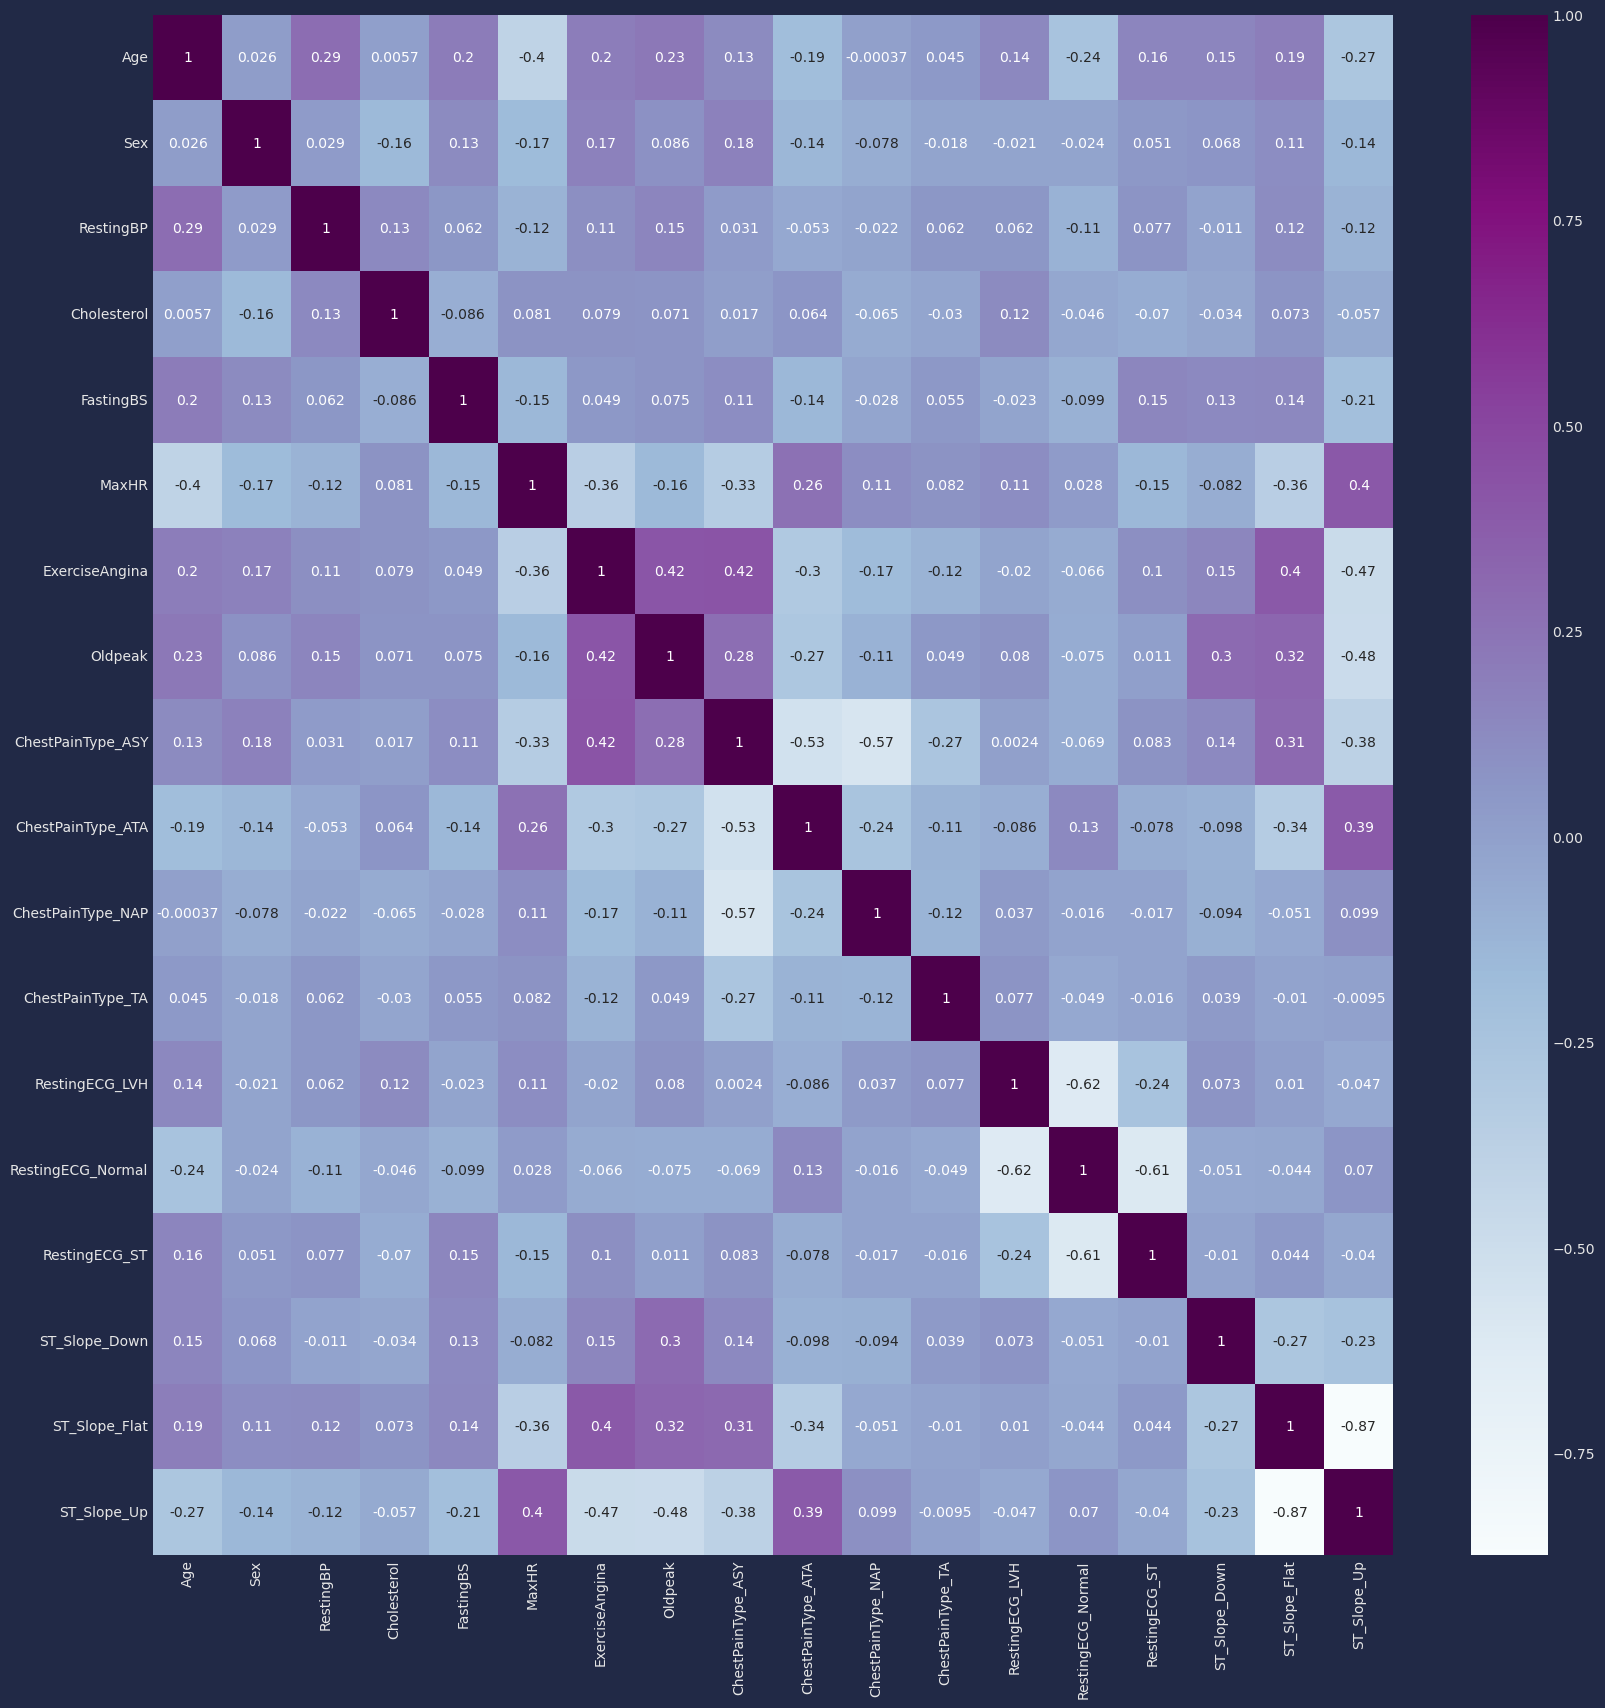

In [32]:
plt.figure(figsize=(20,20))
sns.heatmap(train_X.corr(), annot=True, cmap="BuPu");

# ⚖️ Dealing with imbalaced data

In [33]:
train_y.value_counts()

1    380
0    307
Name: HeartDisease, dtype: int64

In [34]:
oversample = SMOTE(random_state=42, k_neighbors=10)
train_X, train_y = oversample.fit_resample(train_X, train_y)
train_y.value_counts()

0    380
1    380
Name: HeartDisease, dtype: int64

# 📏 Standardization and Normalization

In [35]:
std = StandardScaler()
#mms = MinMaxScaler()

train_X[continuos_f] = std.fit_transform(train_X[continuos_f])
#X_train[continuos_f] = mms.fit_transform(X_train[continuos_f])

#X_val[continuos_f] = std.transform(X_val[continuos_f])
#X_val[continuos_f] = mms.transform(X_val[continuos_f])

test_X[continuos_f] = std.transform(test_X[continuos_f])
#X_test[continuos_f] = mms.transform(X_test[continuos_f])

# 🧼 Feature Selection

In [36]:
fs_clf = SelectKBest(score_func=f_classif, k=15)
X_train = fs_clf.fit_transform(train_X, train_y)
X_test = fs_clf.transform(test_X)
train_X.shape, X_train.shape

((760, 18), (760, 15))

## The most important features

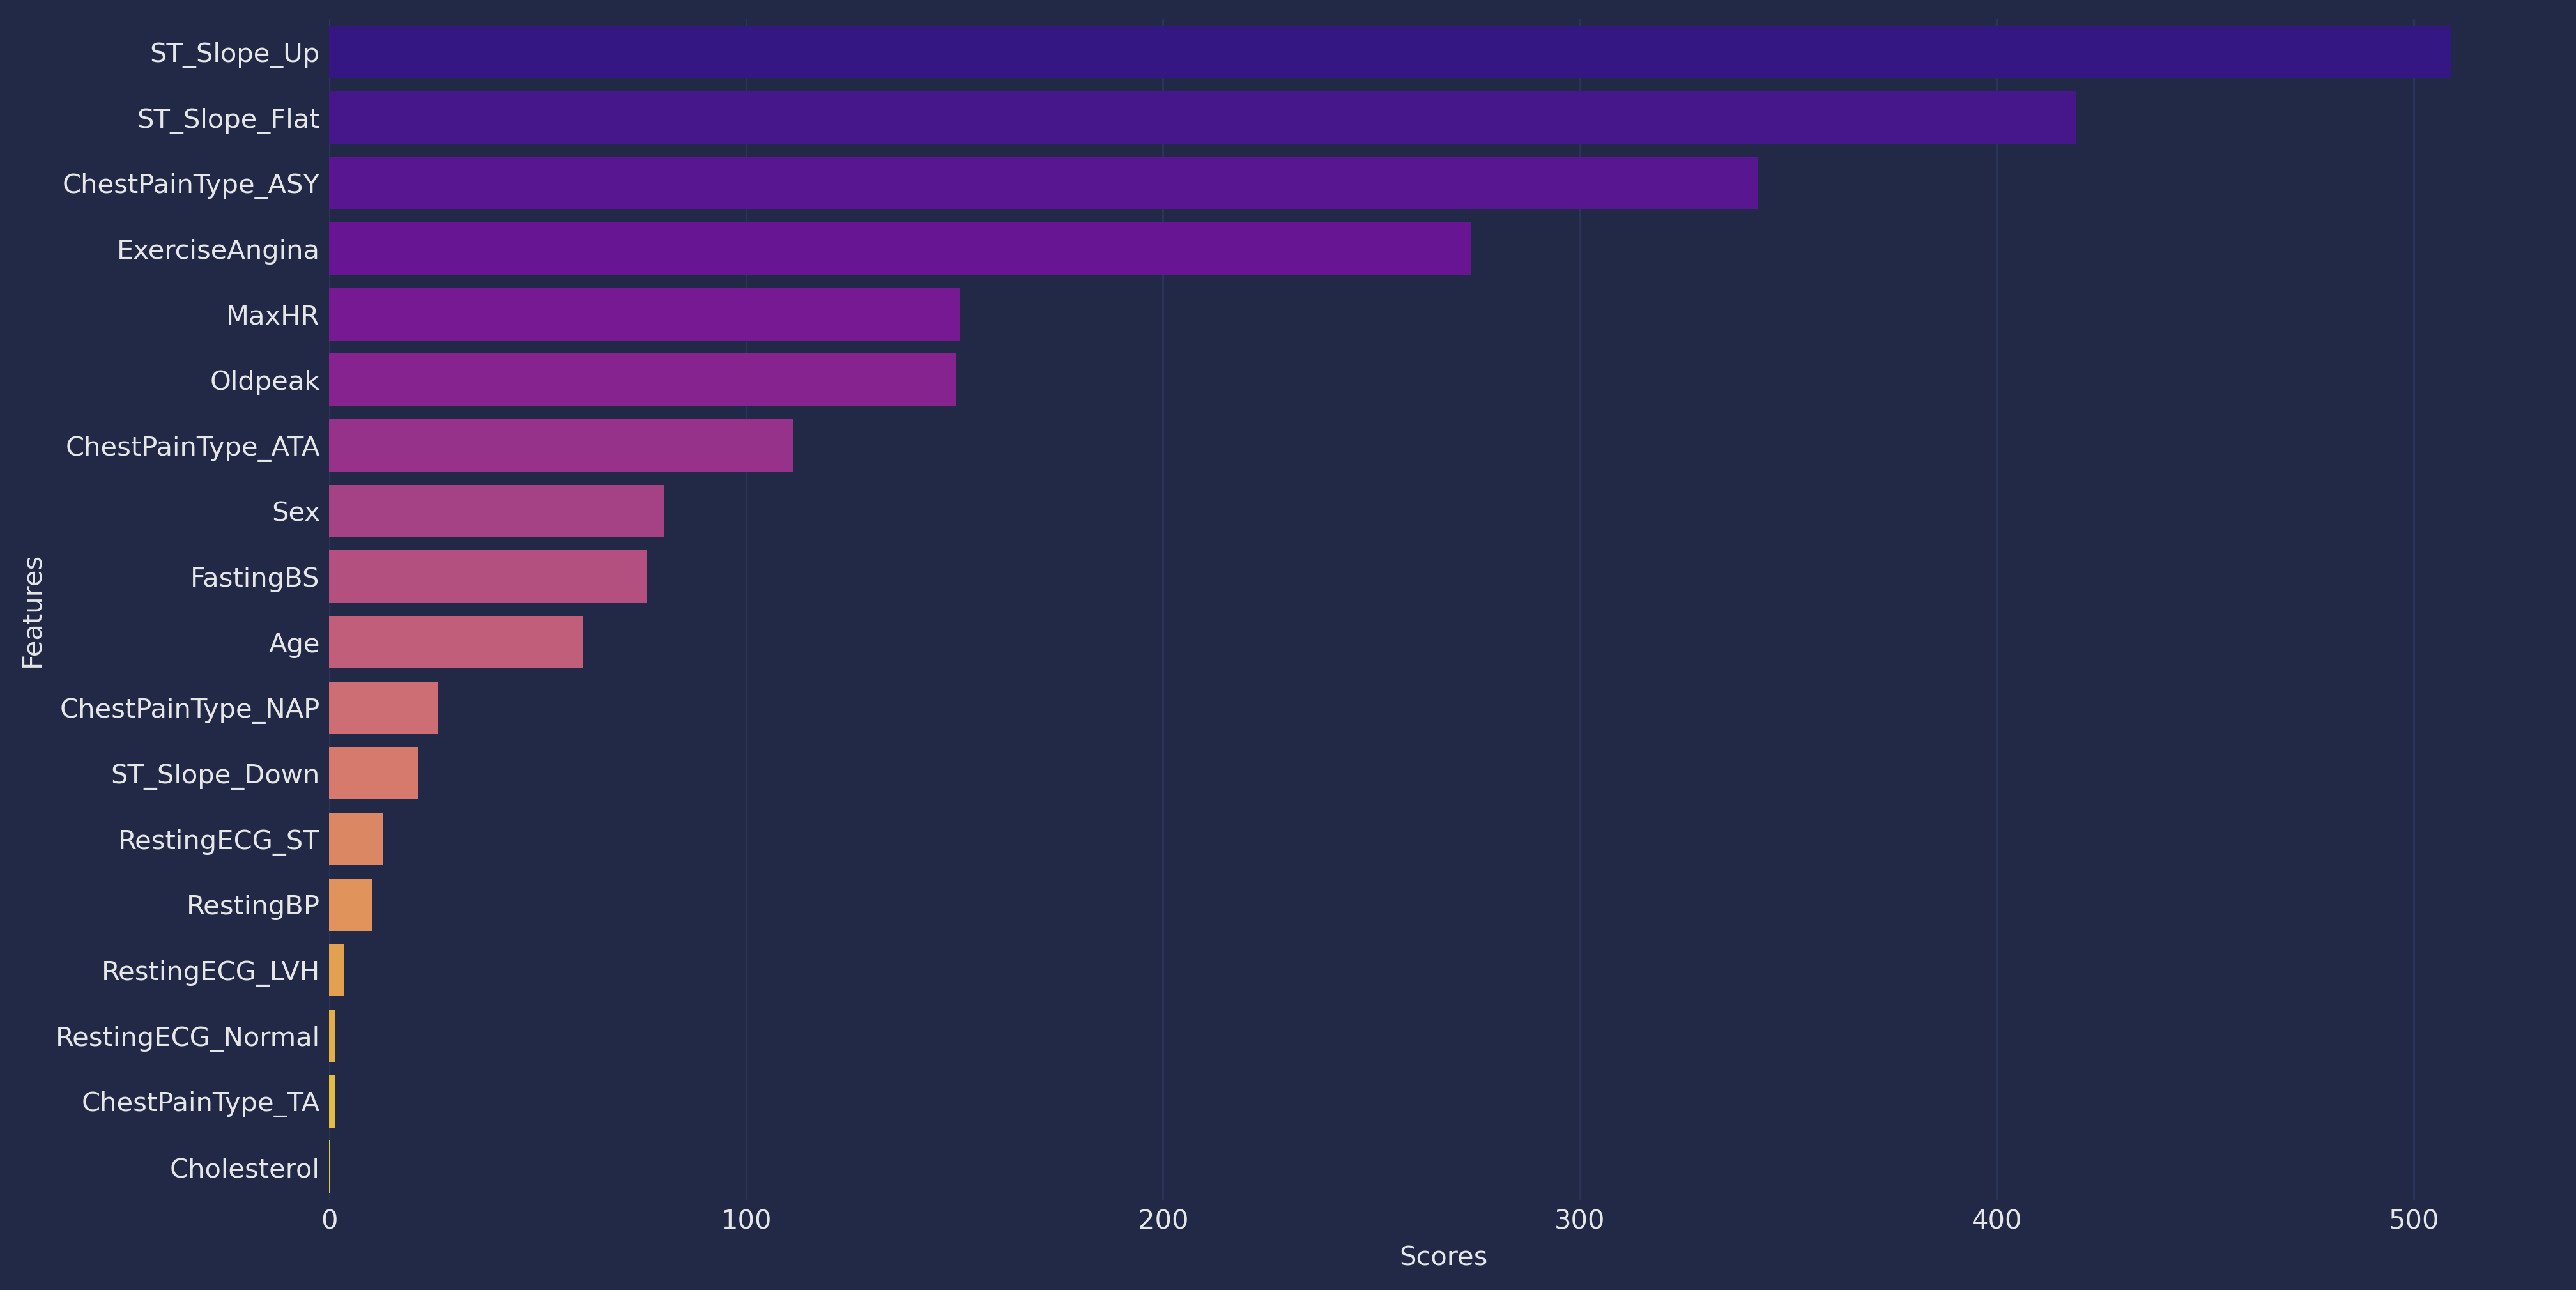

In [37]:
plt.figure(figsize=(15, 8), dpi=300)
feature_scores = pd.DataFrame({"Features":fs_clf.feature_names_in_, "Scores":fs_clf.scores_})
sns.barplot(data=feature_scores, x="Scores", y="Features", palette="plasma", order=feature_scores.sort_values(by="Scores", ascending=False)["Features"]);

In [38]:
y_train = train_y
y_test = test_y

# 🤖 Modeling

We will train three supervised learning models to tasks of classification also we will use grid search to tuning models' hyperparameters, additionally we will evaluate their performance with confusion matrix where:

<table>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Predicted</th>
    </tr>
    <tr>
        <td>Negative</td>
        <td>Positive</td>
    </tr>
    <tr>
        <th rowspan="2">Actual</th>
        <td>Negative</td>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <td>Positive</td>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

Taking into account that:
+ Case negative: Patients with normal conditions (NC)
+ Case positive: Patients with CVDs
+ TN: The prediction tells us that the patient has NC when actually has NC.
+ TP: The prediction tells us that the patient has CVDs when actually has CVDs.
+ FN: The prediction tells us that the patient has NC when actually has CVDs.
+ FP: The prediction tells us that the patient has CVDs when actually has NC.

The worst case is a prediction of type FN, since we would be determining that the patient has normal condition, ignoring the possibility of CVD and exposing the patient to the risk of death. For this reason, we will focus to reduce these type of predictions.
However, the amount of predictions of type FP shouldn't be too large since our model will be very useless.
The score that help us to analysis the amount of predictions of type FN is the recall where:

$Recall = \frac{TP}{TP + FN}\quad\text{if}\quad FN \rightarrow 0 \Longrightarrow Recall \rightarrow 1$

Also:

$Precision = \frac{TP}{TP + FP}\quad\text{if}\quad FP \rightarrow 0 \Longrightarrow Precision \rightarrow 1$

and

$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}\quad\text{if}\quad FN, FP \rightarrow 0 \Longrightarrow F1 \rightarrow 1$

In [39]:
metric = 'recall'

In [40]:
cv = 8
nFeatures = X_train.shape[1]

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Poisitive Rate")
    
def print_scores(y, y_pred):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    print(f"Accuracy:{ac}")
    print(f"Precision:{pr}")
    print(f"Recall:{rc}")
    print(f"F1-score:{f1}")
    return {'ac': ac, 'pr':pr, 'rc':rc, 'f1':f1}

In [41]:
# For purpose of testing the before code.
#raise SystemExit()

## 🟠 K-Nearest Neighbors Classifier

#### We train the model

In [42]:
param_grid = [{
    'n_neighbors':np.arange(5, 21),
    'weights':['uniform', 'distance'],
    'p':[1, 2],
}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, param_grid, cv=cv, scoring=["f1", metric], refit="f1")
grid_knn.fit(X_train, y_train);

In [43]:
grid_knn.best_params_

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

<AxesSubplot:>

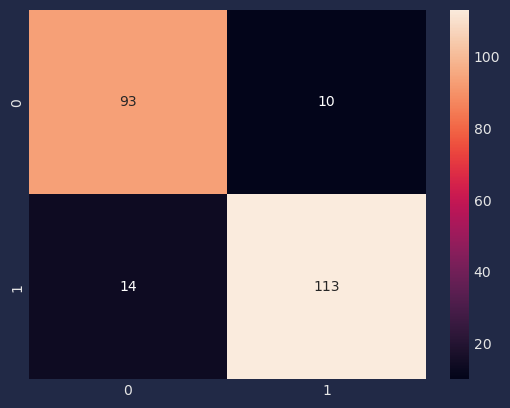

In [44]:
y_test_knn = grid_knn.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_knn)
sns.heatmap(conf_mx, annot=True, fmt='')

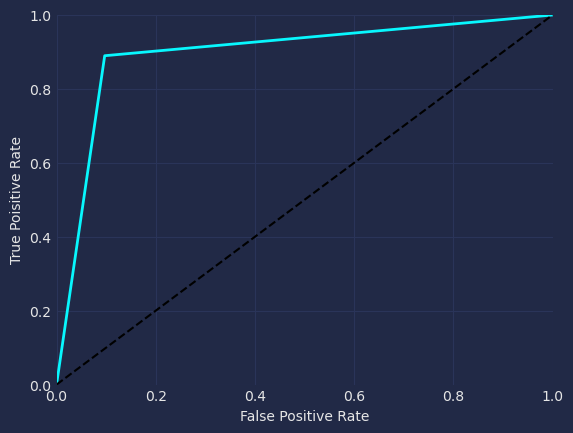

In [45]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_knn)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [46]:
pd.DataFrame(data=classification_report(y_test, y_test_knn, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.869159  0.902913  0.885714  103.000000
1              0.918699  0.889764  0.904000  127.000000
accuracy       0.895652  0.895652  0.895652    0.895652
macro avg      0.893929  0.896338  0.894857  230.000000
weighted avg   0.896514  0.895652  0.895811  230.000000

In [47]:
knn_scores = print_scores(y_test, y_test_knn)

Accuracy:89.56521739130436
Precision:91.869918699187
Recall:88.9763779527559
F1-score:89.58111801242237


## 🟣 C-Support Vector Classifier.

#### We train the model

In [48]:
param_grid = [{
    "C": np.linspace(0.01, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}]

svc_clf = SVC(random_state=42)
grid_svc = GridSearchCV(svc_clf, param_grid, scoring=metric, cv=cv)
grid_svc.fit(X_train, y_train);

In [49]:
grid_svc.best_params_

{'C': 0.34111111111111114, 'gamma': 'scale', 'kernel': 'rbf'}

<AxesSubplot:>

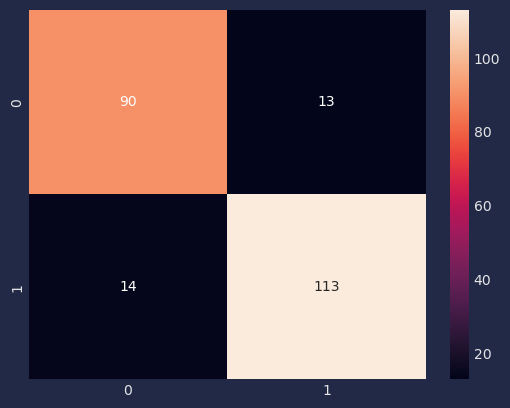

In [50]:
y_test_svc = grid_svc.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_svc)
sns.heatmap(conf_mx, annot=True, fmt='')

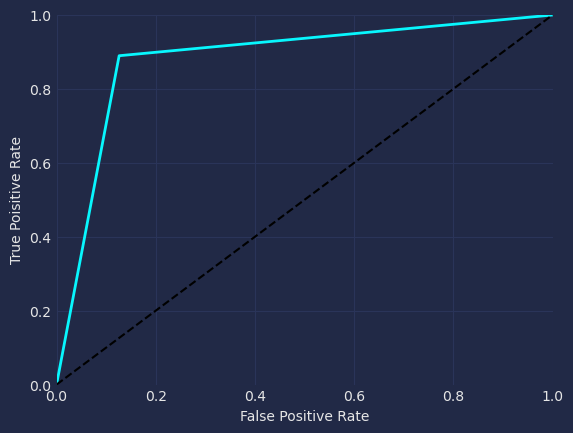

In [51]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_svc)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [52]:
pd.DataFrame(data=classification_report(y_test, y_test_svc, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.865385  0.873786  0.869565  103.000000
1              0.896825  0.889764  0.893281  127.000000
accuracy       0.882609  0.882609  0.882609    0.882609
macro avg      0.881105  0.881775  0.881423  230.000000
weighted avg   0.882745  0.882609  0.882660  230.000000

In [53]:
svc_scores = print_scores(y_test, y_test_svc)

Accuracy:88.26086956521739
Precision:89.68253968253968
Recall:88.9763779527559
F1-score:88.26602509022169


## 🟢 Random Forest Classifier

#### We train the model

In [54]:
param_grid = [{"n_estimators":[100, 200, 300],
               'criterion':['gini','entropy'],
               "max_features":[nFeatures, nFeatures-3, nFeatures-5, nFeatures-12, nFeatures-14],
               "bootstrap": [True],
               "max_depth":np.linspace(1, 10, 10, dtype=int)
              }]
rf_clf = RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(rf_clf, param_grid, cv=cv, scoring=metric)
grid_forest.fit(X_train, y_train);

In [55]:
grid_forest.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 1,
 'n_estimators': 100}

<AxesSubplot:>

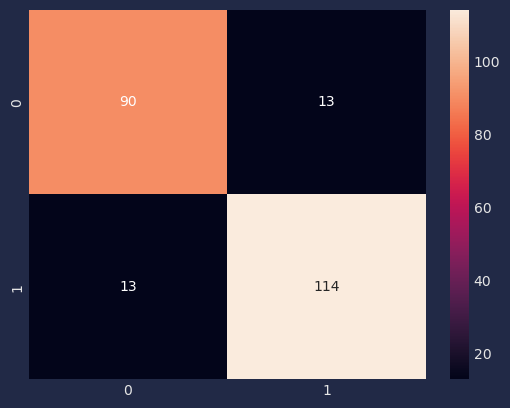

In [56]:
y_test_rf = grid_forest.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_rf)
sns.heatmap(conf_mx, annot=True, fmt='')

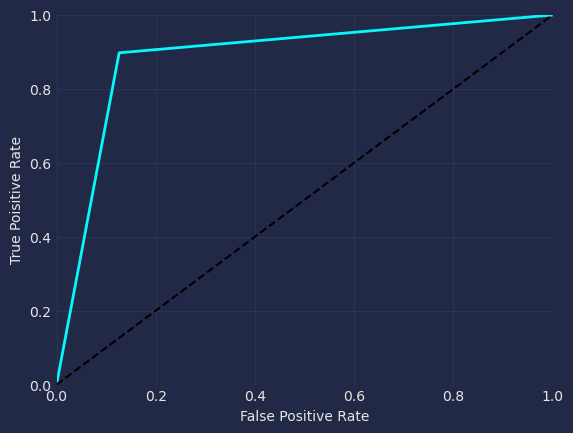

In [57]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_test_rf)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [58]:
pd.DataFrame(data=classification_report(y_test, y_test_rf, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.873786  0.873786  0.873786  103.000000
1              0.897638  0.897638  0.897638  127.000000
accuracy       0.886957  0.886957  0.886957    0.886957
macro avg      0.885712  0.885712  0.885712  230.000000
weighted avg   0.886957  0.886957  0.886957  230.000000

In [59]:
rf_scores = print_scores(y_test, y_test_rf)

Accuracy:88.69565217391305
Precision:89.76377952755905
Recall:89.76377952755905
F1-score:88.69565217391305


# 📏 Model Score Comparisons

In [60]:
scores = pd.DataFrame(data=[list(knn_scores.values()), list(svc_scores.values()), list(rf_scores.values())], columns=list(knn_scores.keys()))
scores = scores.T.rename(columns={0:"K-Nearest Neighbors", 1:"C-Support Vector", 2:"Random Forest"})
scores.style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

According to our focus the best recall score was present for the Random Forest classifier, we must find a balance between recall score and precision score, <span style="color:green; font-weight: bold;">for me the best model is the K-Nearest Neighbors.</span>